In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision import models, datasets
from torchvision.transforms.functional import to_tensor
from torchvision.models import resnet18, ResNet18_Weights

from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# Task 1

In [2]:
# Get the mean, std of the pixel intensity values
def get_mean_and_std():
  # Get unnormalized data with pixel values [0,1]
  dataset = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
  )

  # Split into 60_000/1_000 = 60 batches for faster processing
  loader = DataLoader(dataset, batch_size=1000, shuffle=False)
  mean, std, num_batches = 0.0, 0.0, 0

  for images, _ in loader:
    batch_samples = images.size(0)

    # Convert 28x28 arrray to 784x1
    images = images.view(batch_samples, -1)

    # Get mean and std for pixel values of the batch
    mean += images.mean(dim=1).sum()
    std += images.std(dim=1).sum()
    num_batches += batch_samples

  mean /= num_batches
  std /= num_batches

  return mean.item(), std.item()

In [3]:
# Use the GPU if available to get faster computations done in parallel
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using the device: ", device)

Using the device:  cuda


In [4]:
# Get the train and test datasets loaders
def get_datasets(is_cnn = False, is_Resnet = False, augment_data = True, use_gpu = False):
  # Get the normalization mean and std
  mean, std = get_mean_and_std()
  batch_size = 128

  transforms_list_train = []
  transforms_list_test = []

  # Get the transformations depending on the model type
  if is_Resnet:
    print("Getting datasets for ResNet model")
    transforms_list_train = [
      transforms.Grayscale(num_output_channels=3),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ]

    transforms_list_test = [
      transforms.Grayscale(num_output_channels=3),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ]

  elif is_cnn:
    transforms_list_test = [
      transforms.ToTensor(),
      transforms.Normalize(mean=mean, std=std)
    ]

    transforms_list_train = [
      transforms.ToTensor(),
      transforms.Normalize(mean=mean, std=std)
    ]

    if augment_data:
      print("Getting datasets for CNN with data augmentation")
      transforms_list_train = [
        transforms.RandomRotation(10),
        transforms.RandomAffine(
          degrees=0,
          translate=(0.1, 0.1),
          scale=(0.95, 1.05)
        ),
        # Removed these since they were distoring the image too much
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomVerticalFlip(),
      ] + transforms_list_train
    else:
      print("Getting datasets for CNN without data augmentation")
  else:
    transforms_list_test = [
      transforms.ToTensor(),
      transforms.Normalize(mean=mean, std=std),
      transforms.Lambda(lambda x: x.view(-1))
    ]

    transforms_list_train = [
      transforms.ToTensor(),
      transforms.Normalize(mean=mean, std=std),
      transforms.Lambda(lambda x: x.view(-1))
    ]

    if augment_data:
      print("Getting datasets for NN with data augmentation")
      transforms_list_train = [
        transforms.RandomRotation(10),
        transforms.RandomAffine(
          degrees=0,
          translate=(0.1, 0.1),
          scale=(0.95, 1.05)
        ),
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomVerticalFlip(),
      ] + transforms_list_train
    else:
      print("Getting datasets for NN without data augmentation")

  data_transform_train = transforms.Compose(transforms_list_train)
  data_transform_test = transforms.Compose(transforms_list_test)

  # Get the transformed train and test datset
  complete_train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=data_transform_train)
  complete_test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=data_transform_test)

  # Get the data loader that will be used to train the model
  train_loader = DataLoader(complete_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
  test_loader = DataLoader(complete_test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

  return train_loader, test_loader

In [5]:
# View the first 10 test and training datasets items
def visualize_datasets():
  # Get datasets
  training_data, testing_data = get_datasets(is_cnn=True, augment_data=False)

  train_images, train_labels = next(iter(training_data))
  test_images, test_labels = next(iter(testing_data))

  print("\n\nClassication topology: ")
  print("0 - T-shirt/top")
  print("1 - Trouser")
  print("2 - Pullover")
  print("3 - Dress")
  print("4 - Coat")
  print("5 - Sandal")
  print("6 - Shirt")
  print("7 - Sneaker")
  print("8 - Bag")
  print("9 - Ankle boot\n\n")

  # Print the dimensions of the data
  print(f"Training images shape: {train_images.shape}")
  print(f"Training labels shape: {train_labels.shape}")
  print(f"First 10 training labels: {train_labels[0:10]}")

  plt.figure(figsize=(12, 4))

  # Display what the training and testing images/labels look like
  for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(train_images[i, 0, :, :], cmap='gray')
    plt.axis('off')
    plt.title(f"Train: {train_labels[i].item()}")

    plt.subplot(2, 10, i + 11)
    plt.imshow(test_images[i, 0, :, :], cmap='gray')
    plt.title(f"Test: {test_labels[i].item()}")
    plt.axis('off')
  plt.show()

Getting datasets for CNN without data augmentation


Classication topology: 
0 - T-shirt/top
1 - Trouser
2 - Pullover
3 - Dress
4 - Coat
5 - Sandal
6 - Shirt
7 - Sneaker
8 - Bag
9 - Ankle boot


Training images shape: torch.Size([128, 1, 28, 28])
Training labels shape: torch.Size([128])
First 10 training labels: tensor([3, 3, 0, 1, 6, 8, 5, 4, 2, 3])


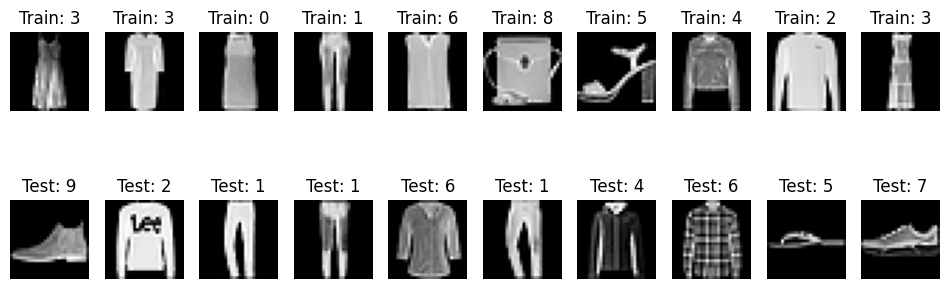

In [23]:
visualize_datasets()

# Task 3

We are running the tasks 3.6, 3.7 and 3.8

## CNN Model


In [6]:
# Formula from class to get the output values for image size
def calculate_image_size(image_size, kernel_size, stride, padding):
  return int((image_size - kernel_size + 2 * padding) / stride + 1)

In [7]:
class CNN(nn.Module):
  # Initialize the model and the parameters for this CNN and attach them to the class
  def __init__(self, *params):
    super().__init__()

    nn_size, conv1, conv2, max_pool, fc1, fc2, dropout = params

    self.nn_size = nn_size
    self.conv1 = conv1
    self.conv2 = conv2
    self.max_pool = max_pool
    self.fc1 = fc1
    self.fc2 = fc2
    self.dropout = dropout

  # Define the actual computation done when the model receives input
  def forward(self, x):
    # first convolution layer
    x = self.conv1(x)
    x = F.relu(x)
    x = self.max_pool(x)

    # Second convolution layer
    x = self.conv2(x)
    x = F.relu(x)
    x = self.max_pool(x)

    # Fully connected component
    x = x.view(-1, self.nn_size)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout(x)
    x = self.fc2(x)

    return x

In [8]:
# Train the model
def train_model(model, train_loader, test_loader, epochs, learning_rate):
  # Start training time and move it to the GPU
  start_time = time.time()
  model.to(device)

  # Define the optimizer and loss function used
  optimizer = Adam(model.parameters(), lr=learning_rate)
  loss = nn.CrossEntropyLoss()

  # Keep track of the data
  train_losses = []
  test_losses = []
  train_accuracy = []
  test_accuracy = []

  # Loop over each epoch
  for epoch in range(epochs):
    model.train()

    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    # Loop over all the images and labels
    for images, labels in tqdm.tqdm(train_loader):
      # Move the images and labels to GPU
      images, labels = images.to(device), labels.to(device)

      # Get predictions and compute loss between predictions and true labels
      outputs = model(images)
      y_hat = torch.argmax(outputs, dim=1)
      loss_value = loss(outputs, labels)

      # Clear old gradients, do backpropagation and update the model params
      optimizer.zero_grad()
      loss_value.backward()
      optimizer.step()

      # Update batch loss and accuracy data
      total_loss += loss_value.item()
      correct_predictions += (y_hat == labels).sum().item()
      total_predictions += len(y_hat)

    # Get and store testing results from the model at this current epoch
    test_losses_iteration, test_accuracy_iteration = test_model(model, test_loader, show_heatmap=False)
    test_losses.append(test_losses_iteration)
    test_accuracy.append(test_accuracy_iteration)

    # Store the training losse and accuracy for this epoch
    train_losses.append(total_loss / len(train_loader))
    train_score = correct_predictions / total_predictions
    train_accuracy.append(train_score)

    print(f"\nEpoch {epoch + 1}, Train Loss: {(total_loss / len(train_loader)):.2f}, Train accuracy: {train_score:.2%}, Test accuracy: {test_accuracy_iteration:.2%}, Test loss: {test_losses_iteration[0]:.2f}\n\n")

  # End the training
  end_time = time.time()
  print(f"Training time: {end_time - start_time:.2f} seconds")

  # Plot the training and testing loss collected for each epoch
  plt.figure(figsize=(12, 4))
  plt.plot(train_losses, label='Train Loss')
  plt.plot(test_losses, label='Test Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.xticks(range(1,epochs, 1))
  plt.title("Losses vs Epoch")
  plt.legend()
  plt.show()

  # Plot the training and testing accuracy collected for each epoch
  plt.figure(figsize=(12, 4))
  plt.plot(train_accuracy, label='Train Accuracy')
  plt.plot(test_accuracy, label='Test Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.xticks(range(1,epochs, 1))
  plt.title("Accuracy vs Epoch")
  plt.legend()
  plt.show()

  # Show the test results with the trained model
  test_model(model, test_loader, show_heatmap=True)

  return model

In [9]:
def test_model(model, test_loader, show_heatmap=False):
  # Put model in eval model and define loss function
  model.eval()
  loss = nn.CrossEntropyLoss()

  # Store all the testing records
  predictions_made = []
  true_labels = []
  test_losses = []
  train_losses = []

  correct = 0
  total = 0
  total_loss = 0

  # Disable gradient computations during testing
  with torch.no_grad():
    # Loop over every testing image/label
    for images, labels in tqdm.tqdm(test_loader):
      # Move images to GPU
      images, labels = images.to(device), labels.to(device)

      # Get predictions and compute loss between predictions and true labels
      outputs = model(images)
      preds = torch.argmax(outputs, dim=1)
      loss_value = loss(outputs, labels)
      total_loss += loss_value.item()

      # Store the computed test values
      predictions_made.extend(preds.cpu().numpy())
      true_labels.extend(labels.cpu().numpy())
      correct += (preds == labels).sum().item()
      total += labels.size(0)

  # Get avarges for stored loss and accuracy
  test_losses.append(total_loss / len(test_loader))
  test_accuracy = correct / total

  # SHow a confusion matrix of the predictions
  if show_heatmap:
    c_matrix = confusion_matrix(true_labels, predictions_made)
    plt.figure(figsize=(5, 4))
    sns.heatmap(c_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=datasets.MNIST.classes, yticklabels=datasets.MNIST.classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

  return test_losses, test_accuracy

## Setting up the different test cases

We will define 5 premade setups to test our models on to compare performance
* `in_channels_1`: Number of channels in the input image passed to the first convolution layer
* `out_channels_1`: Number of output channels after the first convolution layer
* `in_channels_2`: Number of channels going into the second convolution layer (equal to `out_channels_1`)
* `out_channels_2`: Number of output channels aftre the second convolution layer
* `k_1`, `k_2`: Kernel sizes for the first and second convolution layers
* `s_1`, `s_2`: Strides of the first and second convolution layers
* `p_1`, `p_2`: Padding of the first and second convolution layers
* `pool_k`: Kernel size of the max-pooling layers
* `pool_s`: Stride of the max-pooling layers
* `pool_p`: Padding of the max-pooling layers
* `image_size_original`: Original size of the input image
* `image_size_1 ... image_size_4`: Intermediate image sizes after each convolution and pooling operation to get a final image size, computed using `calculate_image_size`
* `image_size`: Final size of the image after the last pooling layer
* `in_features_nn_1`: Number of input features to the first fully connected layer (`out_channels_2 * image_size`)
* `out_features_nn_1`: Number of neurons in the first fully connected layer (set to 256 as stated in the assignment)
* `in_features_nn_2`: Number of inputs to the final classification layer (equal to `out_features_nn_1`)
* `out_features_nn_2`: Number of output classes (10 for this classifcation assignment)
* `conv1`, `conv2`: The two convolution layers using the parameters above
* `max_pool`: The shared max-pooling layer used after each convolution
* `fc1`, `fc2`: The fully connected layers after the convolution steps
* `dropout`: A dropout layer applied before classification
* `nn_size`: Size of the flattened images entering the first fully connected layer

In [28]:
def get_params_1():
  in_channels_1 = 1
  out_channels_1 = 32
  in_channels_2 = out_channels_1
  out_channels_2 = 64

  k_1 = 2
  s_1 = 1
  p_1 = 0

  k_2 = 2
  s_2 = 1
  p_2 = 0

  pool_k = 2
  pool_s = 1
  pool_p = 0

  image_size_original = 28
  image_size_1 = calculate_image_size(image_size_original, k_1, s_1, p_1)
  image_size_2 = calculate_image_size(image_size_1, pool_k, pool_s, pool_p)
  image_size_3 = calculate_image_size(image_size_2, k_2, s_2, p_2)
  image_size_4 = calculate_image_size(image_size_3, pool_k, pool_s, pool_p)
  image_size = image_size_4 * image_size_4

  in_features_nn_1 = out_channels_2 * image_size
  out_features_nn_1 = 256
  in_features_nn_2 = out_features_nn_1
  out_features_nn_2 = 10

  nn_size = in_features_nn_1

  conv1 = nn.Conv2d(in_channels=in_channels_1,
                         out_channels=out_channels_1,
                         kernel_size=k_1,
                         stride=s_1,
                         padding=p_1)
  conv2 = nn.Conv2d(in_channels=in_channels_2,
                         out_channels=out_channels_2,
                         kernel_size=k_2,
                         stride=s_2,
                         padding=p_2)
  max_pool = nn.MaxPool2d(kernel_size=pool_k, stride=pool_s, padding=pool_p)

  fc1 = nn.Linear(in_features=in_features_nn_1, out_features=out_features_nn_1)
  fc2 = nn.Linear(in_features=in_features_nn_2, out_features=out_features_nn_2)

  dropout = nn.Dropout(0.25)

  return nn_size, conv1, conv2, max_pool, fc1, fc2, dropout

In [29]:
def get_params_2():
  in_channels_1 = 1
  out_channels_1 = 16
  in_channels_2 = out_channels_1
  out_channels_2 = 32

  k_1 = 3
  s_1 = 1
  p_1 = 1

  k_2 = 3
  s_2 = 1
  p_2 = 1

  pool_k = 2
  pool_s = 2
  pool_p = 0

  image_size_original = 28
  image_size_1 = calculate_image_size(image_size_original, k_1, s_1, p_1)
  image_size_2 = calculate_image_size(image_size_1, pool_k, pool_s, pool_p)
  image_size_3 = calculate_image_size(image_size_2, k_2, s_2, p_2)
  image_size_4 = calculate_image_size(image_size_3, pool_k, pool_s, pool_p)
  image_size = image_size_4 * image_size_4

  in_features_nn_1 = out_channels_2 * image_size
  out_features_nn_1 = 256
  in_features_nn_2 = out_features_nn_1
  out_features_nn_2 = 10

  nn_size = in_features_nn_1

  conv1 = nn.Conv2d(in_channels=in_channels_1,
                         out_channels=out_channels_1,
                         kernel_size=k_1,
                         stride=s_1,
                         padding=p_1)
  conv2 = nn.Conv2d(in_channels=in_channels_2,
                         out_channels=out_channels_2,
                         kernel_size=k_2,
                         stride=s_2,
                         padding=p_2)
  max_pool = nn.MaxPool2d(kernel_size=pool_k, stride=pool_s, padding=pool_p)

  fc1 = nn.Linear(in_features=in_features_nn_1, out_features=out_features_nn_1)
  fc2 = nn.Linear(in_features=in_features_nn_2, out_features=out_features_nn_2)

  dropout = nn.Dropout(0.25)

  return nn_size, conv1, conv2, max_pool, fc1, fc2, dropout

In [30]:
def get_params_3():
  in_channels_1 = 1
  out_channels_1 = 32
  in_channels_2 = out_channels_1
  out_channels_2 = 64

  k_1 = 3
  s_1 = 1
  p_1 = 1

  k_2 = 3
  s_2 = 1
  p_2 = 1

  pool_k = 2
  pool_s = 2
  pool_p = 0

  image_size_original = 28
  image_size_1 = calculate_image_size(image_size_original, k_1, s_1, p_1)
  image_size_2 = calculate_image_size(image_size_1, pool_k, pool_s, pool_p)
  image_size_3 = calculate_image_size(image_size_2, k_2, s_2, p_2)
  image_size_4 = calculate_image_size(image_size_3, pool_k, pool_s, pool_p)
  image_size = image_size_4 * image_size_4

  in_features_nn_1 = out_channels_2 * image_size
  out_features_nn_1 = 256
  in_features_nn_2 = out_features_nn_1
  out_features_nn_2 = 10

  nn_size = in_features_nn_1

  conv1 = nn.Conv2d(in_channels=in_channels_1,
                         out_channels=out_channels_1,
                         kernel_size=k_1,
                         stride=s_1,
                         padding=p_1)
  conv2 = nn.Conv2d(in_channels=in_channels_2,
                         out_channels=out_channels_2,
                         kernel_size=k_2,
                         stride=s_2,
                         padding=p_2)
  max_pool = nn.MaxPool2d(kernel_size=pool_k, stride=pool_s, padding=pool_p)

  fc1 = nn.Linear(in_features=in_features_nn_1, out_features=out_features_nn_1)
  fc2 = nn.Linear(in_features=in_features_nn_2, out_features=out_features_nn_2)

  dropout = nn.Dropout(0.25)

  return nn_size, conv1, conv2, max_pool, fc1, fc2, dropout

In [31]:
def get_params_4():
  in_channels_1 = 1
  out_channels_1 = 16
  in_channels_2 = out_channels_1
  out_channels_2 = 32

  k_1 = 5
  s_1 = 1
  p_1 = 2

  k_2 = 5
  s_2 = 1
  p_2 = 2

  pool_k = 2
  pool_s = 2
  pool_p = 0

  image_size_original = 28
  image_size_1 = calculate_image_size(image_size_original, k_1, s_1, p_1)
  image_size_2 = calculate_image_size(image_size_1, pool_k, pool_s, pool_p)
  image_size_3 = calculate_image_size(image_size_2, k_2, s_2, p_2)
  image_size_4 = calculate_image_size(image_size_3, pool_k, pool_s, pool_p)
  image_size = image_size_4 * image_size_4

  in_features_nn_1 = out_channels_2 * image_size
  out_features_nn_1 = 256
  in_features_nn_2 = out_features_nn_1
  out_features_nn_2 = 10

  nn_size = in_features_nn_1

  conv1 = nn.Conv2d(in_channels=in_channels_1,
                         out_channels=out_channels_1,
                         kernel_size=k_1,
                         stride=s_1,
                         padding=p_1)
  conv2 = nn.Conv2d(in_channels=in_channels_2,
                         out_channels=out_channels_2,
                         kernel_size=k_2,
                         stride=s_2,
                         padding=p_2)
  max_pool = nn.MaxPool2d(kernel_size=pool_k, stride=pool_s, padding=pool_p)

  fc1 = nn.Linear(in_features=in_features_nn_1, out_features=out_features_nn_1)
  fc2 = nn.Linear(in_features=in_features_nn_2, out_features=out_features_nn_2)

  dropout = nn.Dropout(0.25)

  return nn_size, conv1, conv2, max_pool, fc1, fc2, dropout

In [32]:
def get_params_5():
  in_channels_1 = 1
  out_channels_1 = 32
  in_channels_2 = out_channels_1
  out_channels_2 = 64

  k_1 = 5
  s_1 = 1
  p_1 = 2

  k_2 = 5
  s_2 = 1
  p_2 = 2

  pool_k = 2
  pool_s = 2
  pool_p = 0

  image_size_original = 28
  image_size_1 = calculate_image_size(image_size_original, k_1, s_1, p_1)
  image_size_2 = calculate_image_size(image_size_1, pool_k, pool_s, pool_p)
  image_size_3 = calculate_image_size(image_size_2, k_2, s_2, p_2)
  image_size_4 = calculate_image_size(image_size_3, pool_k, pool_s, pool_p)
  image_size = image_size_4 * image_size_4

  in_features_nn_1 = out_channels_2 * image_size
  out_features_nn_1 = 256
  in_features_nn_2 = out_features_nn_1
  out_features_nn_2 = 10

  nn_size = in_features_nn_1

  conv1 = nn.Conv2d(in_channels=in_channels_1,
                         out_channels=out_channels_1,
                         kernel_size=k_1,
                         stride=s_1,
                         padding=p_1)
  conv2 = nn.Conv2d(in_channels=in_channels_2,
                         out_channels=out_channels_2,
                         kernel_size=k_2,
                         stride=s_2,
                         padding=p_2)
  max_pool = nn.MaxPool2d(kernel_size=pool_k, stride=pool_s, padding=pool_p)

  fc1 = nn.Linear(in_features=in_features_nn_1, out_features=out_features_nn_1)
  fc2 = nn.Linear(in_features=in_features_nn_2, out_features=out_features_nn_2)

  dropout = nn.Dropout(0.25)

  return nn_size, conv1, conv2, max_pool, fc1, fc2, dropout

## Training on non-augmented data

In [33]:
# Get the data and define the learning rate and epochs for the next 5 experiments
learning_rate = 0.001
epochs = 15
train_loader, test_loader = get_datasets(is_cnn=True, augment_data=False)

Getting datasets for CNN without data augmentation


100%|██████████| 79/79 [00:02<00:00, 37.02it/s]



Epoch 1, Train Loss: 0.43, Train accuracy: 84.84%, Test accuracy: 89.40%, Test loss: 0.29




100%|██████████| 79/79 [00:01<00:00, 42.98it/s]



Epoch 2, Train Loss: 0.26, Train accuracy: 90.42%, Test accuracy: 90.64%, Test loss: 0.26




100%|██████████| 79/79 [00:01<00:00, 42.73it/s]



Epoch 3, Train Loss: 0.22, Train accuracy: 92.05%, Test accuracy: 91.24%, Test loss: 0.24




100%|██████████| 79/79 [00:01<00:00, 43.28it/s]



Epoch 4, Train Loss: 0.18, Train accuracy: 93.34%, Test accuracy: 91.90%, Test loss: 0.23




100%|██████████| 79/79 [00:01<00:00, 41.79it/s]



Epoch 5, Train Loss: 0.15, Train accuracy: 94.51%, Test accuracy: 92.23%, Test loss: 0.23




100%|██████████| 79/79 [00:01<00:00, 43.52it/s]



Epoch 6, Train Loss: 0.12, Train accuracy: 95.50%, Test accuracy: 92.49%, Test loss: 0.23




100%|██████████| 79/79 [00:02<00:00, 33.04it/s]



Epoch 7, Train Loss: 0.10, Train accuracy: 96.25%, Test accuracy: 92.69%, Test loss: 0.24




100%|██████████| 79/79 [00:02<00:00, 32.76it/s]



Epoch 8, Train Loss: 0.08, Train accuracy: 96.88%, Test accuracy: 92.63%, Test loss: 0.26




100%|██████████| 79/79 [00:01<00:00, 41.87it/s]



Epoch 9, Train Loss: 0.07, Train accuracy: 97.44%, Test accuracy: 92.46%, Test loss: 0.26




100%|██████████| 79/79 [00:01<00:00, 42.12it/s]



Epoch 10, Train Loss: 0.06, Train accuracy: 97.90%, Test accuracy: 92.86%, Test loss: 0.29




100%|██████████| 79/79 [00:01<00:00, 43.26it/s]



Epoch 11, Train Loss: 0.05, Train accuracy: 98.25%, Test accuracy: 92.73%, Test loss: 0.30




100%|██████████| 79/79 [00:02<00:00, 29.93it/s]



Epoch 12, Train Loss: 0.04, Train accuracy: 98.49%, Test accuracy: 92.78%, Test loss: 0.32




100%|██████████| 79/79 [00:01<00:00, 43.39it/s]



Epoch 13, Train Loss: 0.03, Train accuracy: 98.76%, Test accuracy: 92.88%, Test loss: 0.36




100%|██████████| 79/79 [00:01<00:00, 43.25it/s]



Epoch 14, Train Loss: 0.03, Train accuracy: 98.88%, Test accuracy: 92.40%, Test loss: 0.37




100%|██████████| 79/79 [00:01<00:00, 43.23it/s]



Epoch 15, Train Loss: 0.03, Train accuracy: 98.95%, Test accuracy: 92.49%, Test loss: 0.36


Training time: 225.67 seconds


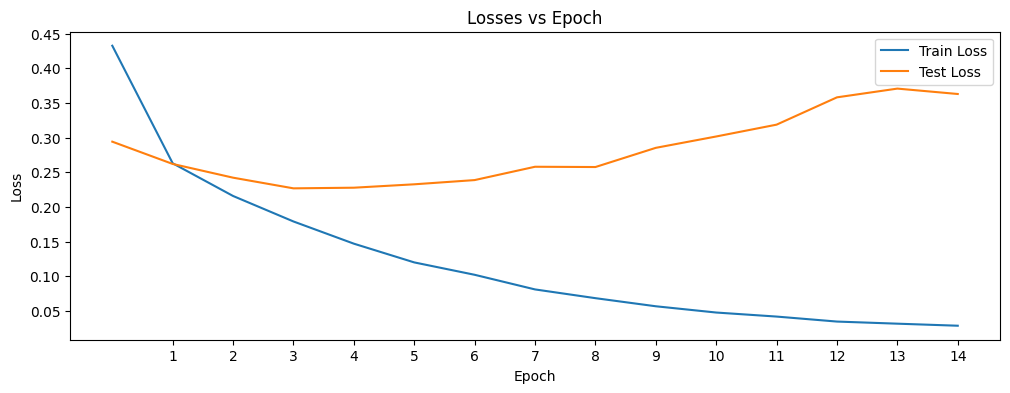

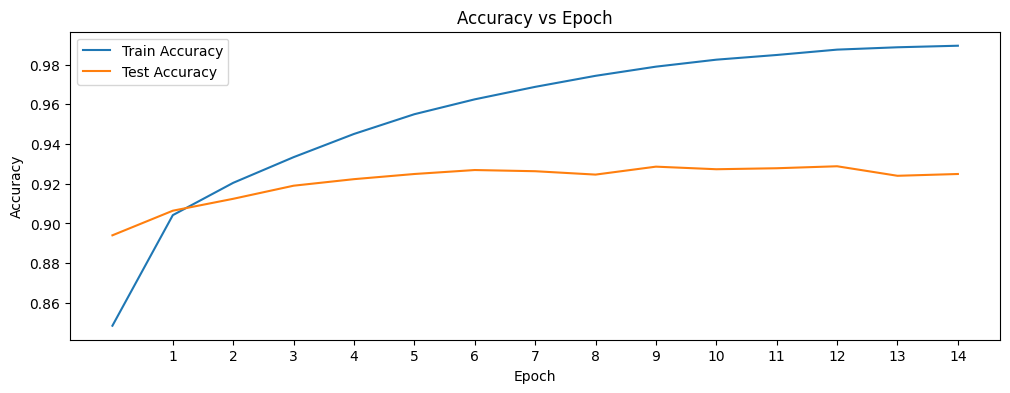

100%|██████████| 79/79 [00:01<00:00, 42.97it/s]


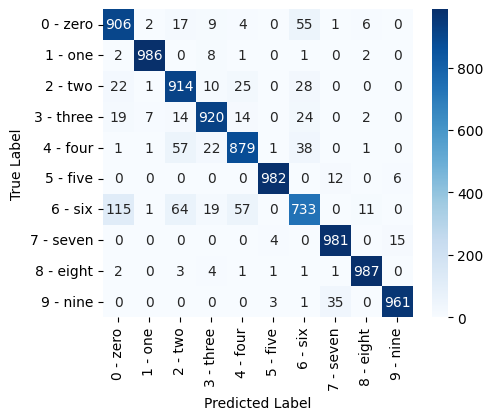

In [34]:
# Train model with parameters in test 1
params_1 = get_params_1()
untrained_model = CNN(*params_1)
model = train_model(untrained_model, train_loader, test_loader, epochs, learning_rate)

100%|██████████| 79/79 [00:01<00:00, 43.41it/s]



Epoch 1, Train Loss: 0.49, Train accuracy: 82.24%, Test accuracy: 86.30%, Test loss: 0.36




100%|██████████| 79/79 [00:02<00:00, 35.97it/s]



Epoch 2, Train Loss: 0.32, Train accuracy: 88.57%, Test accuracy: 88.81%, Test loss: 0.31




100%|██████████| 79/79 [00:02<00:00, 29.88it/s]



Epoch 3, Train Loss: 0.27, Train accuracy: 90.06%, Test accuracy: 89.79%, Test loss: 0.27




100%|██████████| 79/79 [00:01<00:00, 44.56it/s]



Epoch 4, Train Loss: 0.24, Train accuracy: 91.18%, Test accuracy: 90.22%, Test loss: 0.27




100%|██████████| 79/79 [00:01<00:00, 44.35it/s]



Epoch 5, Train Loss: 0.22, Train accuracy: 91.92%, Test accuracy: 90.55%, Test loss: 0.26




100%|██████████| 79/79 [00:01<00:00, 44.53it/s]



Epoch 6, Train Loss: 0.20, Train accuracy: 92.45%, Test accuracy: 91.12%, Test loss: 0.25




100%|██████████| 79/79 [00:01<00:00, 44.68it/s]



Epoch 7, Train Loss: 0.18, Train accuracy: 93.23%, Test accuracy: 91.13%, Test loss: 0.25




100%|██████████| 79/79 [00:01<00:00, 43.47it/s]



Epoch 8, Train Loss: 0.17, Train accuracy: 93.76%, Test accuracy: 91.17%, Test loss: 0.24




100%|██████████| 79/79 [00:01<00:00, 42.24it/s]



Epoch 9, Train Loss: 0.15, Train accuracy: 94.21%, Test accuracy: 91.47%, Test loss: 0.24




100%|██████████| 79/79 [00:01<00:00, 45.33it/s]



Epoch 10, Train Loss: 0.14, Train accuracy: 94.74%, Test accuracy: 91.69%, Test loss: 0.24




100%|██████████| 79/79 [00:01<00:00, 44.13it/s]



Epoch 11, Train Loss: 0.13, Train accuracy: 95.06%, Test accuracy: 92.21%, Test loss: 0.24




100%|██████████| 79/79 [00:02<00:00, 34.95it/s]



Epoch 12, Train Loss: 0.12, Train accuracy: 95.61%, Test accuracy: 91.69%, Test loss: 0.26




100%|██████████| 79/79 [00:02<00:00, 30.88it/s]



Epoch 13, Train Loss: 0.11, Train accuracy: 95.97%, Test accuracy: 91.77%, Test loss: 0.26




100%|██████████| 79/79 [00:01<00:00, 43.87it/s]



Epoch 14, Train Loss: 0.10, Train accuracy: 96.17%, Test accuracy: 91.78%, Test loss: 0.26




100%|██████████| 79/79 [00:01<00:00, 44.45it/s]



Epoch 15, Train Loss: 0.09, Train accuracy: 96.53%, Test accuracy: 91.57%, Test loss: 0.28


Training time: 210.53 seconds


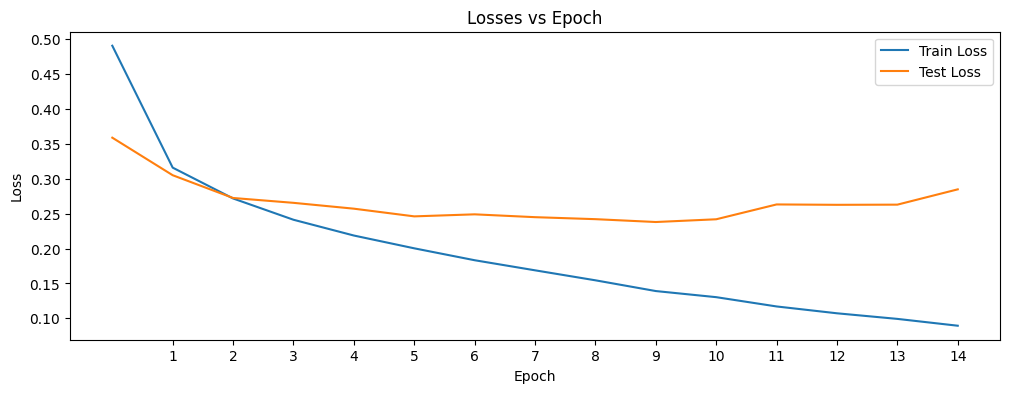

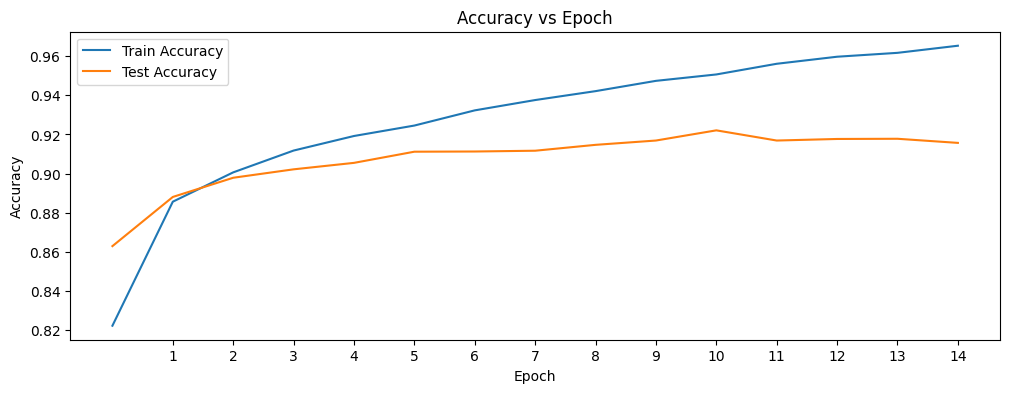

100%|██████████| 79/79 [00:01<00:00, 42.91it/s]


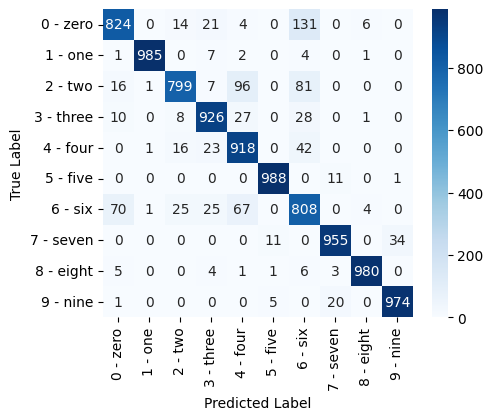

In [35]:
# Train model with parameters in test 2
params_2 = get_params_2()
untrained_model = CNN(*params_2)
model = train_model(untrained_model, train_loader, test_loader, epochs, learning_rate)

100%|██████████| 79/79 [00:01<00:00, 43.79it/s]



Epoch 1, Train Loss: 0.45, Train accuracy: 83.55%, Test accuracy: 86.23%, Test loss: 0.36




100%|██████████| 79/79 [00:01<00:00, 43.02it/s]



Epoch 2, Train Loss: 0.29, Train accuracy: 89.49%, Test accuracy: 89.39%, Test loss: 0.28




100%|██████████| 79/79 [00:01<00:00, 44.48it/s]



Epoch 3, Train Loss: 0.24, Train accuracy: 91.10%, Test accuracy: 90.72%, Test loss: 0.25




100%|██████████| 79/79 [00:02<00:00, 32.06it/s]



Epoch 4, Train Loss: 0.21, Train accuracy: 92.17%, Test accuracy: 90.91%, Test loss: 0.25




100%|██████████| 79/79 [00:02<00:00, 31.24it/s]



Epoch 5, Train Loss: 0.19, Train accuracy: 93.08%, Test accuracy: 91.41%, Test loss: 0.24




100%|██████████| 79/79 [00:01<00:00, 43.16it/s]



Epoch 6, Train Loss: 0.17, Train accuracy: 93.64%, Test accuracy: 92.12%, Test loss: 0.23




100%|██████████| 79/79 [00:01<00:00, 43.53it/s]



Epoch 7, Train Loss: 0.15, Train accuracy: 94.30%, Test accuracy: 90.93%, Test loss: 0.26




100%|██████████| 79/79 [00:01<00:00, 43.69it/s]



Epoch 8, Train Loss: 0.13, Train accuracy: 94.98%, Test accuracy: 92.44%, Test loss: 0.22




100%|██████████| 79/79 [00:01<00:00, 44.79it/s]



Epoch 9, Train Loss: 0.12, Train accuracy: 95.48%, Test accuracy: 92.06%, Test loss: 0.24




100%|██████████| 79/79 [00:01<00:00, 44.34it/s]



Epoch 10, Train Loss: 0.10, Train accuracy: 96.11%, Test accuracy: 92.45%, Test loss: 0.24




100%|██████████| 79/79 [00:01<00:00, 43.72it/s]



Epoch 11, Train Loss: 0.09, Train accuracy: 96.49%, Test accuracy: 92.43%, Test loss: 0.25




100%|██████████| 79/79 [00:01<00:00, 44.53it/s]



Epoch 12, Train Loss: 0.08, Train accuracy: 96.93%, Test accuracy: 91.99%, Test loss: 0.27




100%|██████████| 79/79 [00:02<00:00, 32.48it/s]



Epoch 13, Train Loss: 0.07, Train accuracy: 97.24%, Test accuracy: 92.06%, Test loss: 0.27




100%|██████████| 79/79 [00:02<00:00, 33.73it/s]



Epoch 14, Train Loss: 0.06, Train accuracy: 97.63%, Test accuracy: 92.50%, Test loss: 0.29




100%|██████████| 79/79 [00:01<00:00, 43.98it/s]



Epoch 15, Train Loss: 0.06, Train accuracy: 97.96%, Test accuracy: 92.19%, Test loss: 0.30


Training time: 212.77 seconds


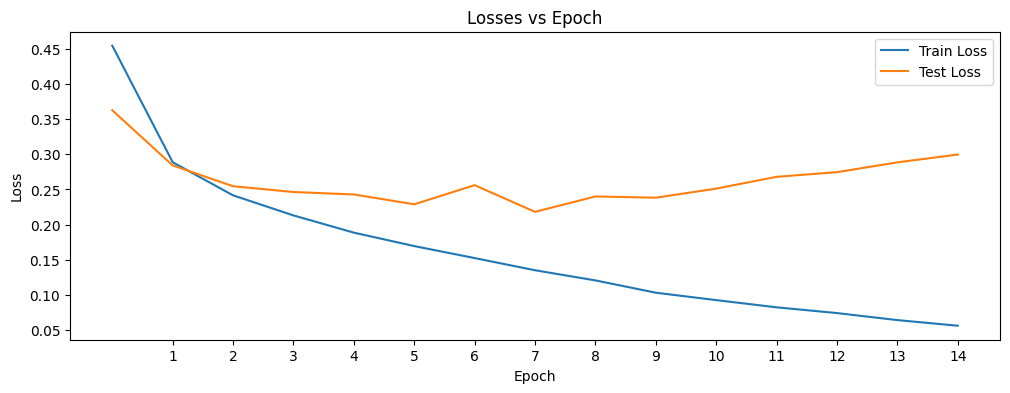

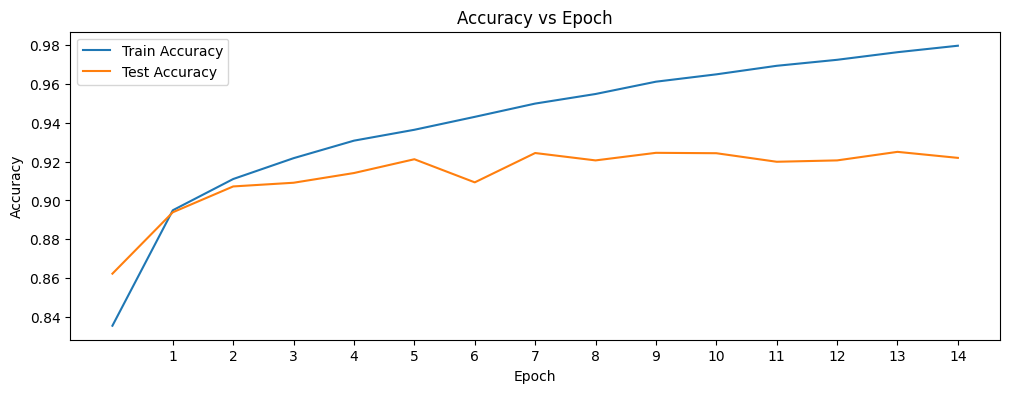

100%|██████████| 79/79 [00:01<00:00, 43.87it/s]


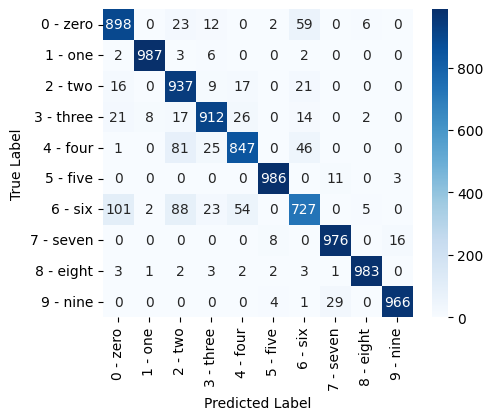

In [36]:
# Train model with parameters in test 3
params_3 = get_params_3()
untrained_model = CNN(*params_3)
model = train_model(untrained_model, train_loader, test_loader, epochs, learning_rate)

100%|██████████| 79/79 [00:01<00:00, 43.04it/s]



Epoch 1, Train Loss: 0.49, Train accuracy: 82.50%, Test accuracy: 87.63%, Test loss: 0.34




100%|██████████| 79/79 [00:01<00:00, 44.28it/s]



Epoch 2, Train Loss: 0.31, Train accuracy: 88.82%, Test accuracy: 89.10%, Test loss: 0.31




100%|██████████| 79/79 [00:01<00:00, 42.22it/s]



Epoch 3, Train Loss: 0.27, Train accuracy: 90.12%, Test accuracy: 89.39%, Test loss: 0.28




100%|██████████| 79/79 [00:01<00:00, 42.69it/s]



Epoch 4, Train Loss: 0.24, Train accuracy: 91.23%, Test accuracy: 90.39%, Test loss: 0.26




100%|██████████| 79/79 [00:02<00:00, 32.31it/s]



Epoch 5, Train Loss: 0.22, Train accuracy: 92.00%, Test accuracy: 90.35%, Test loss: 0.26




100%|██████████| 79/79 [00:02<00:00, 33.44it/s]



Epoch 6, Train Loss: 0.20, Train accuracy: 92.62%, Test accuracy: 91.15%, Test loss: 0.24




100%|██████████| 79/79 [00:01<00:00, 43.19it/s]



Epoch 7, Train Loss: 0.18, Train accuracy: 93.35%, Test accuracy: 90.88%, Test loss: 0.25




100%|██████████| 79/79 [00:01<00:00, 44.28it/s]



Epoch 8, Train Loss: 0.16, Train accuracy: 93.95%, Test accuracy: 91.55%, Test loss: 0.23




100%|██████████| 79/79 [00:01<00:00, 40.52it/s]



Epoch 9, Train Loss: 0.15, Train accuracy: 94.46%, Test accuracy: 91.37%, Test loss: 0.25




100%|██████████| 79/79 [00:01<00:00, 43.69it/s]



Epoch 10, Train Loss: 0.13, Train accuracy: 95.08%, Test accuracy: 91.37%, Test loss: 0.27




100%|██████████| 79/79 [00:01<00:00, 43.21it/s]



Epoch 11, Train Loss: 0.12, Train accuracy: 95.42%, Test accuracy: 91.50%, Test loss: 0.26




100%|██████████| 79/79 [00:01<00:00, 43.77it/s]



Epoch 12, Train Loss: 0.11, Train accuracy: 95.82%, Test accuracy: 91.67%, Test loss: 0.27




100%|██████████| 79/79 [00:02<00:00, 35.82it/s]



Epoch 13, Train Loss: 0.10, Train accuracy: 96.26%, Test accuracy: 91.82%, Test loss: 0.28




100%|██████████| 79/79 [00:02<00:00, 30.13it/s]



Epoch 14, Train Loss: 0.09, Train accuracy: 96.63%, Test accuracy: 91.74%, Test loss: 0.30




100%|██████████| 79/79 [00:01<00:00, 43.12it/s]



Epoch 15, Train Loss: 0.08, Train accuracy: 96.90%, Test accuracy: 92.15%, Test loss: 0.28


Training time: 213.69 seconds


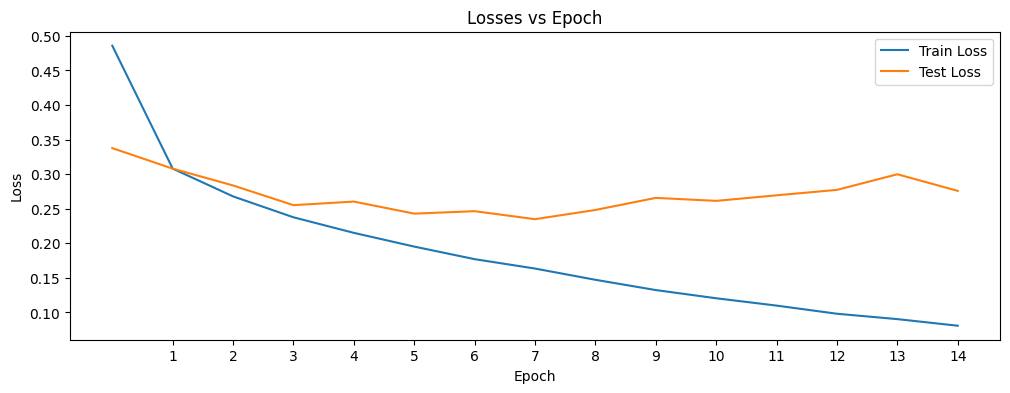

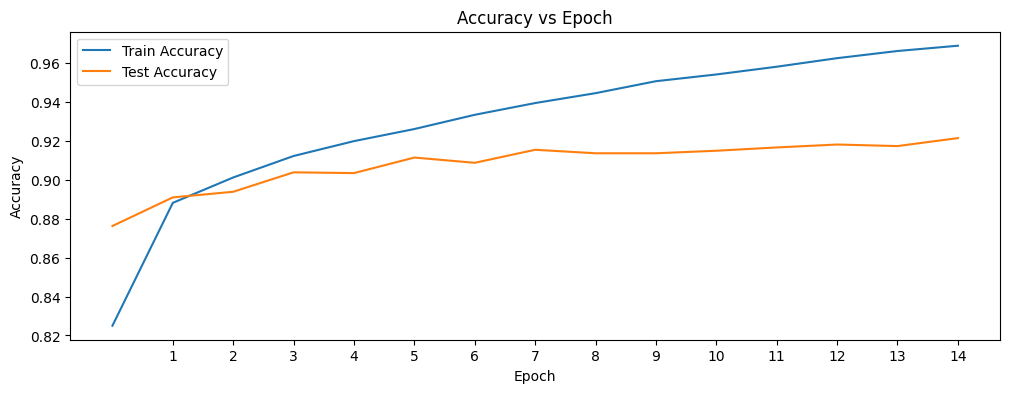

100%|██████████| 79/79 [00:01<00:00, 43.73it/s]


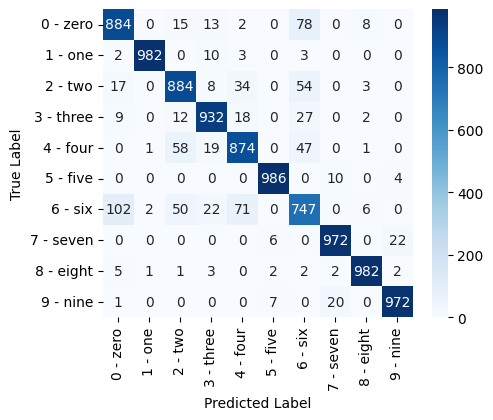

In [37]:
# Train model with parameters in test 4
params_4 = get_params_4()
untrained_model = CNN(*params_4)
model = train_model(untrained_model, train_loader, test_loader, epochs, learning_rate)

100%|██████████| 79/79 [00:01<00:00, 43.49it/s]



Epoch 1, Train Loss: 0.45, Train accuracy: 83.81%, Test accuracy: 88.28%, Test loss: 0.32




100%|██████████| 79/79 [00:01<00:00, 43.44it/s]



Epoch 2, Train Loss: 0.28, Train accuracy: 89.68%, Test accuracy: 89.99%, Test loss: 0.27




100%|██████████| 79/79 [00:01<00:00, 43.91it/s]



Epoch 3, Train Loss: 0.24, Train accuracy: 91.23%, Test accuracy: 90.75%, Test loss: 0.25




100%|██████████| 79/79 [00:01<00:00, 43.38it/s]



Epoch 4, Train Loss: 0.21, Train accuracy: 92.26%, Test accuracy: 90.93%, Test loss: 0.24




100%|██████████| 79/79 [00:02<00:00, 28.92it/s]



Epoch 5, Train Loss: 0.18, Train accuracy: 93.25%, Test accuracy: 91.34%, Test loss: 0.23




100%|██████████| 79/79 [00:01<00:00, 42.26it/s]



Epoch 6, Train Loss: 0.16, Train accuracy: 93.99%, Test accuracy: 91.12%, Test loss: 0.25




100%|██████████| 79/79 [00:01<00:00, 42.82it/s]



Epoch 7, Train Loss: 0.14, Train accuracy: 94.55%, Test accuracy: 91.79%, Test loss: 0.24




100%|██████████| 79/79 [00:01<00:00, 43.48it/s]



Epoch 8, Train Loss: 0.12, Train accuracy: 95.36%, Test accuracy: 91.36%, Test loss: 0.27




100%|██████████| 79/79 [00:01<00:00, 42.59it/s]



Epoch 9, Train Loss: 0.11, Train accuracy: 95.75%, Test accuracy: 91.04%, Test loss: 0.27




100%|██████████| 79/79 [00:01<00:00, 42.23it/s]



Epoch 10, Train Loss: 0.10, Train accuracy: 96.34%, Test accuracy: 92.12%, Test loss: 0.26




100%|██████████| 79/79 [00:01<00:00, 43.65it/s]



Epoch 11, Train Loss: 0.08, Train accuracy: 96.81%, Test accuracy: 92.23%, Test loss: 0.27




100%|██████████| 79/79 [00:02<00:00, 34.46it/s]



Epoch 12, Train Loss: 0.08, Train accuracy: 97.12%, Test accuracy: 92.19%, Test loss: 0.29




100%|██████████| 79/79 [00:02<00:00, 30.30it/s]



Epoch 13, Train Loss: 0.07, Train accuracy: 97.44%, Test accuracy: 92.12%, Test loss: 0.29




100%|██████████| 79/79 [00:01<00:00, 42.86it/s]



Epoch 14, Train Loss: 0.06, Train accuracy: 97.61%, Test accuracy: 92.22%, Test loss: 0.31




100%|██████████| 79/79 [00:01<00:00, 41.82it/s]



Epoch 15, Train Loss: 0.06, Train accuracy: 97.89%, Test accuracy: 91.96%, Test loss: 0.35


Training time: 215.72 seconds


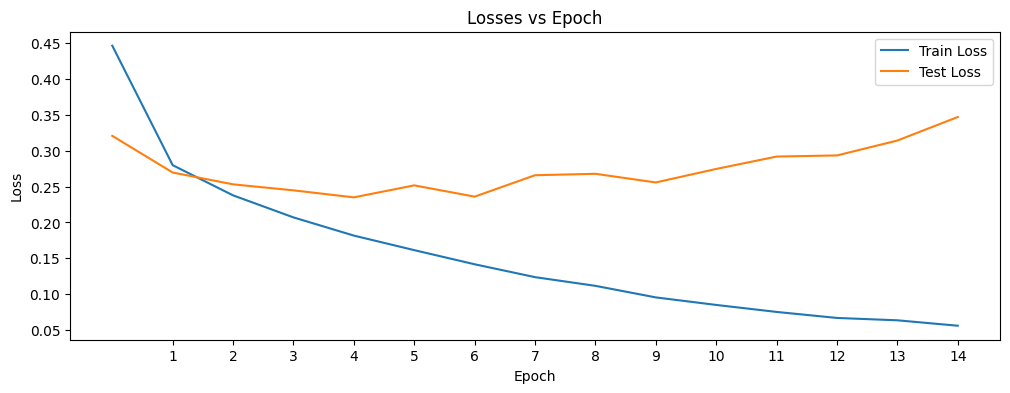

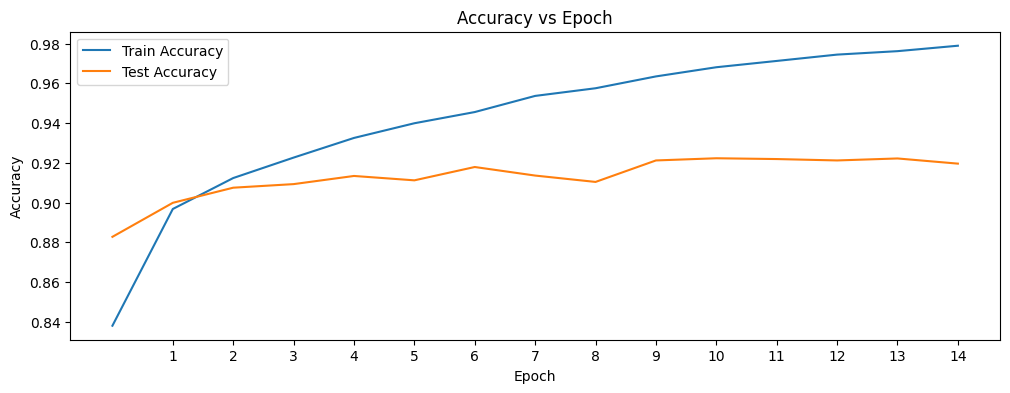

100%|██████████| 79/79 [00:01<00:00, 40.55it/s]


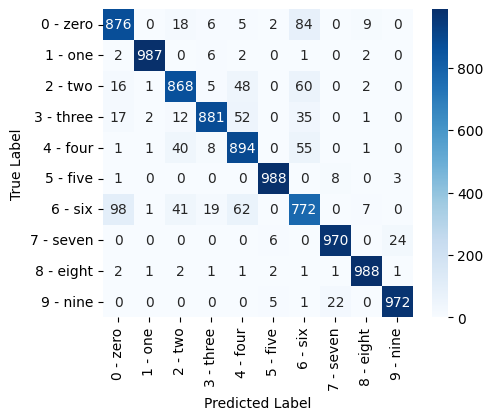

In [38]:
# Train model with parameters in test 5
params_5 = get_params_5()
untrained_model = CNN(*params_5)
model = train_model(untrained_model, train_loader, test_loader, epochs, learning_rate)

## Training on augmented data

In [39]:
# Get the data and define the learning rate and epochs for the next 5 experiments
learning_rate = 0.001
epochs = 15
train_loader, test_loader = get_datasets(is_cnn=True)

Getting datasets for CNN with data augmentation


100%|██████████| 79/79 [00:02<00:00, 32.36it/s]



Epoch 1, Train Loss: 0.68, Train accuracy: 75.45%, Test accuracy: 85.52%, Test loss: 0.40




100%|██████████| 79/79 [00:01<00:00, 44.81it/s]



Epoch 2, Train Loss: 0.46, Train accuracy: 83.14%, Test accuracy: 87.21%, Test loss: 0.35




100%|██████████| 79/79 [00:01<00:00, 42.61it/s]



Epoch 3, Train Loss: 0.40, Train accuracy: 85.27%, Test accuracy: 87.88%, Test loss: 0.33




100%|██████████| 79/79 [00:01<00:00, 41.06it/s]



Epoch 4, Train Loss: 0.37, Train accuracy: 86.51%, Test accuracy: 89.24%, Test loss: 0.29




100%|██████████| 79/79 [00:02<00:00, 39.06it/s]



Epoch 5, Train Loss: 0.35, Train accuracy: 87.18%, Test accuracy: 89.77%, Test loss: 0.28




100%|██████████| 79/79 [00:01<00:00, 40.10it/s]



Epoch 6, Train Loss: 0.33, Train accuracy: 87.67%, Test accuracy: 90.42%, Test loss: 0.27




100%|██████████| 79/79 [00:01<00:00, 39.82it/s]



Epoch 7, Train Loss: 0.32, Train accuracy: 88.18%, Test accuracy: 90.28%, Test loss: 0.27




100%|██████████| 79/79 [00:02<00:00, 31.25it/s]



Epoch 8, Train Loss: 0.31, Train accuracy: 88.60%, Test accuracy: 90.45%, Test loss: 0.27




100%|██████████| 79/79 [00:02<00:00, 31.66it/s]



Epoch 9, Train Loss: 0.30, Train accuracy: 88.88%, Test accuracy: 91.55%, Test loss: 0.24




100%|██████████| 79/79 [00:01<00:00, 42.21it/s]



Epoch 10, Train Loss: 0.30, Train accuracy: 89.11%, Test accuracy: 91.20%, Test loss: 0.25




100%|██████████| 79/79 [00:01<00:00, 41.65it/s]



Epoch 11, Train Loss: 0.29, Train accuracy: 89.43%, Test accuracy: 91.25%, Test loss: 0.24




100%|██████████| 79/79 [00:01<00:00, 41.88it/s]



Epoch 12, Train Loss: 0.28, Train accuracy: 89.62%, Test accuracy: 91.78%, Test loss: 0.23




100%|██████████| 79/79 [00:01<00:00, 43.07it/s]



Epoch 13, Train Loss: 0.28, Train accuracy: 89.83%, Test accuracy: 91.20%, Test loss: 0.24




100%|██████████| 79/79 [00:01<00:00, 42.20it/s]



Epoch 14, Train Loss: 0.28, Train accuracy: 89.86%, Test accuracy: 91.72%, Test loss: 0.23




100%|██████████| 79/79 [00:02<00:00, 29.90it/s]



Epoch 15, Train Loss: 0.27, Train accuracy: 90.07%, Test accuracy: 92.31%, Test loss: 0.22


Training time: 357.40 seconds


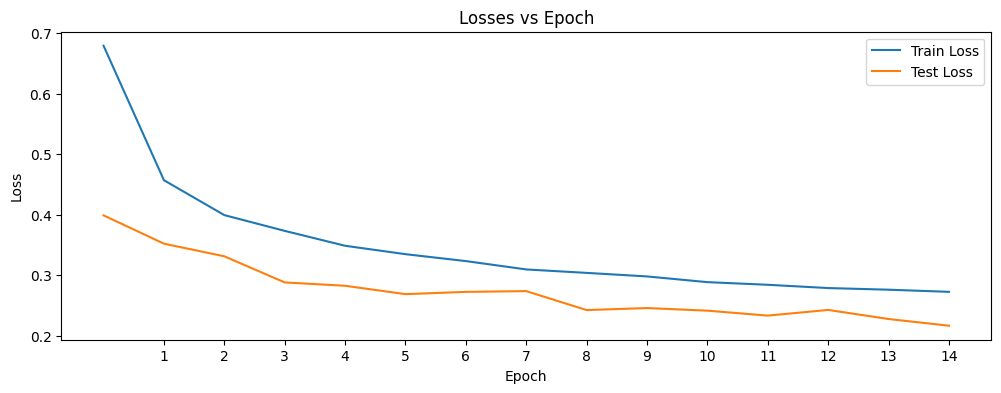

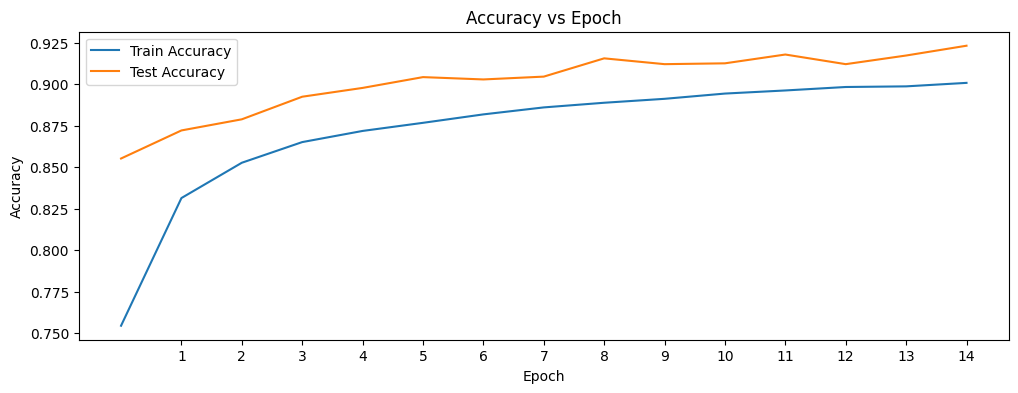

100%|██████████| 79/79 [00:01<00:00, 41.77it/s]


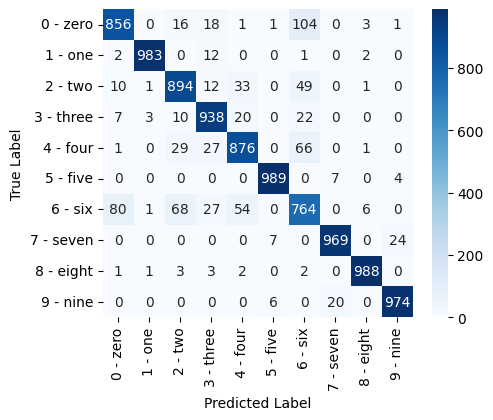

In [40]:
# Train model with parameters in test 1
params_1 = get_params_1()
untrained_model = CNN(*params_1)
model = train_model(untrained_model, train_loader, test_loader, epochs, learning_rate)

100%|██████████| 79/79 [00:02<00:00, 30.05it/s]



Epoch 1, Train Loss: 0.70, Train accuracy: 73.72%, Test accuracy: 83.07%, Test loss: 0.45




100%|██████████| 79/79 [00:01<00:00, 43.27it/s]



Epoch 2, Train Loss: 0.50, Train accuracy: 81.34%, Test accuracy: 86.11%, Test loss: 0.38




100%|██████████| 79/79 [00:01<00:00, 43.69it/s]



Epoch 3, Train Loss: 0.44, Train accuracy: 83.79%, Test accuracy: 86.87%, Test loss: 0.35




100%|██████████| 79/79 [00:01<00:00, 41.79it/s]



Epoch 4, Train Loss: 0.40, Train accuracy: 85.08%, Test accuracy: 88.35%, Test loss: 0.32




100%|██████████| 79/79 [00:02<00:00, 36.04it/s]



Epoch 5, Train Loss: 0.37, Train accuracy: 86.16%, Test accuracy: 88.87%, Test loss: 0.30




100%|██████████| 79/79 [00:01<00:00, 43.06it/s]



Epoch 6, Train Loss: 0.36, Train accuracy: 86.78%, Test accuracy: 89.12%, Test loss: 0.29




100%|██████████| 79/79 [00:01<00:00, 43.86it/s]



Epoch 7, Train Loss: 0.34, Train accuracy: 87.21%, Test accuracy: 89.62%, Test loss: 0.29




100%|██████████| 79/79 [00:01<00:00, 43.25it/s]



Epoch 8, Train Loss: 0.33, Train accuracy: 87.70%, Test accuracy: 89.81%, Test loss: 0.28




100%|██████████| 79/79 [00:02<00:00, 35.79it/s]



Epoch 9, Train Loss: 0.33, Train accuracy: 88.01%, Test accuracy: 89.70%, Test loss: 0.28




100%|██████████| 79/79 [00:01<00:00, 43.64it/s]



Epoch 10, Train Loss: 0.31, Train accuracy: 88.35%, Test accuracy: 89.23%, Test loss: 0.29




100%|██████████| 79/79 [00:01<00:00, 43.62it/s]



Epoch 11, Train Loss: 0.31, Train accuracy: 88.47%, Test accuracy: 90.58%, Test loss: 0.26




100%|██████████| 79/79 [00:01<00:00, 43.42it/s]



Epoch 12, Train Loss: 0.30, Train accuracy: 88.85%, Test accuracy: 90.79%, Test loss: 0.25




100%|██████████| 79/79 [00:02<00:00, 30.66it/s]



Epoch 13, Train Loss: 0.30, Train accuracy: 88.95%, Test accuracy: 90.63%, Test loss: 0.25




100%|██████████| 79/79 [00:01<00:00, 43.46it/s]



Epoch 14, Train Loss: 0.29, Train accuracy: 89.33%, Test accuracy: 90.46%, Test loss: 0.26




100%|██████████| 79/79 [00:01<00:00, 42.55it/s]



Epoch 15, Train Loss: 0.29, Train accuracy: 89.18%, Test accuracy: 91.01%, Test loss: 0.25


Training time: 335.00 seconds


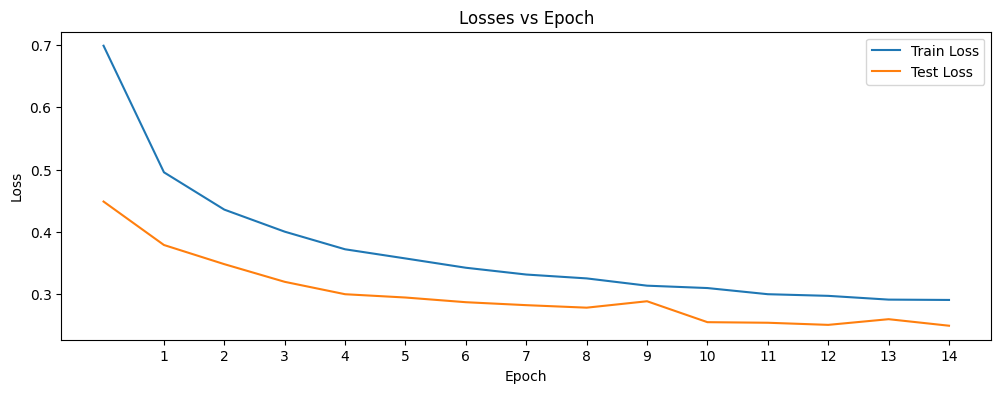

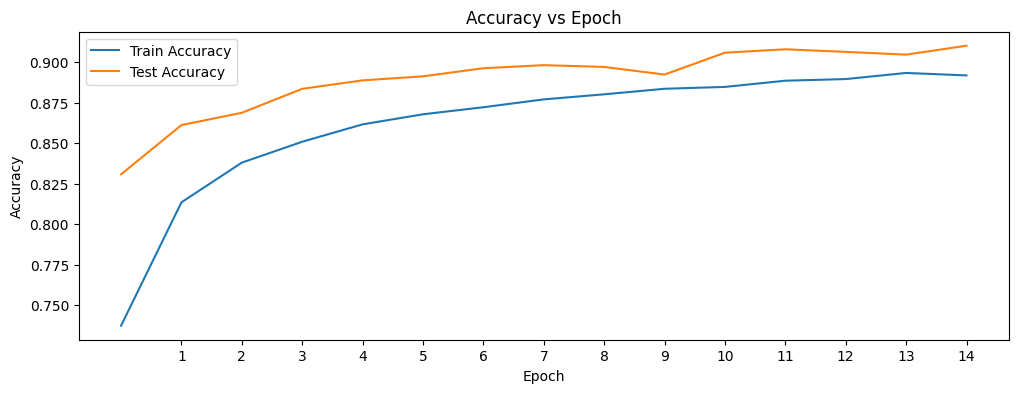

100%|██████████| 79/79 [00:01<00:00, 44.03it/s]


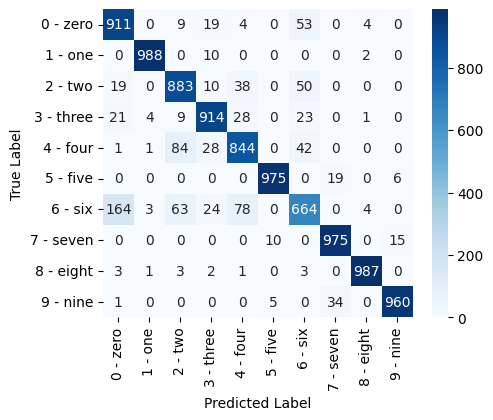

In [41]:
# Train model with parameters in test 2
params_2 = get_params_2()
untrained_model = CNN(*params_2)
model = train_model(untrained_model, train_loader, test_loader, epochs, learning_rate)

100%|██████████| 79/79 [00:02<00:00, 31.34it/s]



Epoch 1, Train Loss: 0.63, Train accuracy: 76.33%, Test accuracy: 84.93%, Test loss: 0.42




100%|██████████| 79/79 [00:01<00:00, 42.09it/s]



Epoch 2, Train Loss: 0.44, Train accuracy: 83.52%, Test accuracy: 87.08%, Test loss: 0.34




100%|██████████| 79/79 [00:02<00:00, 27.25it/s]



Epoch 3, Train Loss: 0.39, Train accuracy: 85.57%, Test accuracy: 88.81%, Test loss: 0.30




100%|██████████| 79/79 [00:02<00:00, 37.48it/s]



Epoch 4, Train Loss: 0.35, Train accuracy: 86.95%, Test accuracy: 89.52%, Test loss: 0.29




100%|██████████| 79/79 [00:02<00:00, 34.38it/s]



Epoch 5, Train Loss: 0.33, Train accuracy: 87.64%, Test accuracy: 89.77%, Test loss: 0.28




100%|██████████| 79/79 [00:01<00:00, 41.89it/s]



Epoch 6, Train Loss: 0.32, Train accuracy: 88.26%, Test accuracy: 89.98%, Test loss: 0.28




100%|██████████| 79/79 [00:01<00:00, 42.40it/s]



Epoch 7, Train Loss: 0.31, Train accuracy: 88.71%, Test accuracy: 89.78%, Test loss: 0.28




100%|██████████| 79/79 [00:01<00:00, 42.12it/s]



Epoch 8, Train Loss: 0.30, Train accuracy: 89.02%, Test accuracy: 91.31%, Test loss: 0.25




100%|██████████| 79/79 [00:02<00:00, 38.67it/s]



Epoch 9, Train Loss: 0.29, Train accuracy: 89.45%, Test accuracy: 91.38%, Test loss: 0.24




100%|██████████| 79/79 [00:02<00:00, 36.92it/s]



Epoch 10, Train Loss: 0.28, Train accuracy: 89.62%, Test accuracy: 91.62%, Test loss: 0.23




100%|██████████| 79/79 [00:01<00:00, 42.40it/s]



Epoch 11, Train Loss: 0.27, Train accuracy: 90.03%, Test accuracy: 91.87%, Test loss: 0.24




100%|██████████| 79/79 [00:01<00:00, 43.53it/s]



Epoch 12, Train Loss: 0.27, Train accuracy: 90.13%, Test accuracy: 91.93%, Test loss: 0.23




100%|██████████| 79/79 [00:01<00:00, 43.36it/s]



Epoch 13, Train Loss: 0.26, Train accuracy: 90.16%, Test accuracy: 92.03%, Test loss: 0.23




100%|██████████| 79/79 [00:02<00:00, 31.42it/s]



Epoch 14, Train Loss: 0.26, Train accuracy: 90.35%, Test accuracy: 91.82%, Test loss: 0.23




100%|██████████| 79/79 [00:01<00:00, 42.68it/s]



Epoch 15, Train Loss: 0.25, Train accuracy: 90.77%, Test accuracy: 91.94%, Test loss: 0.23


Training time: 373.15 seconds


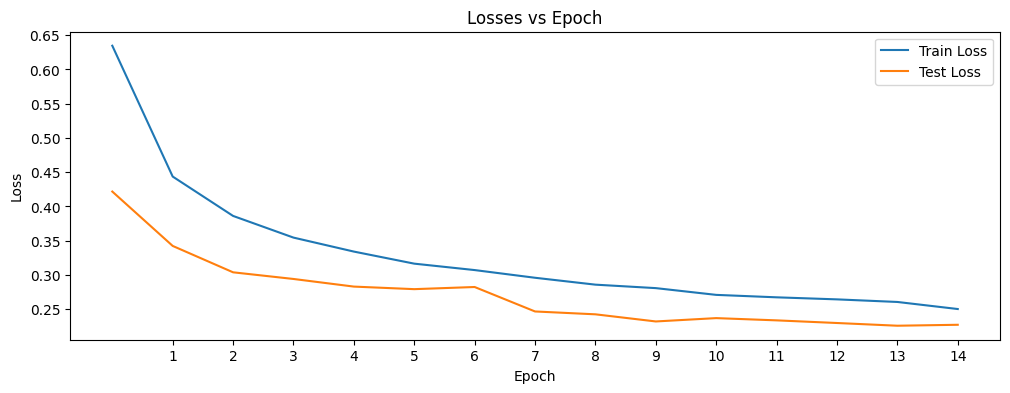

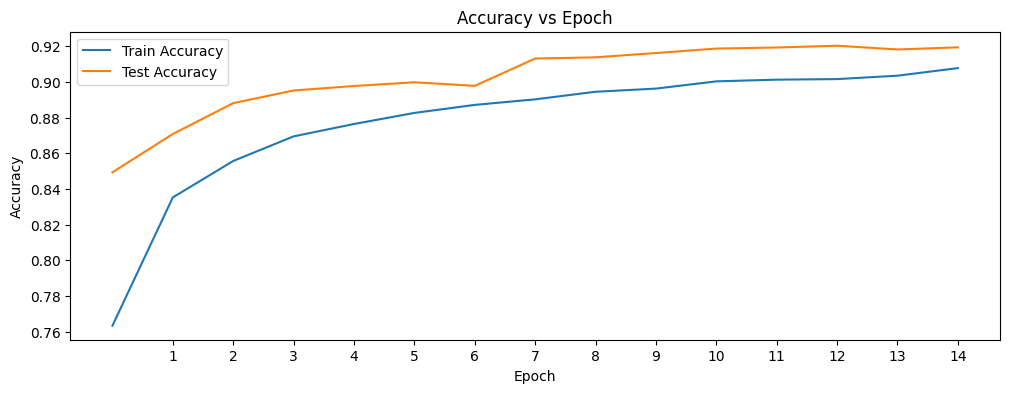

100%|██████████| 79/79 [00:02<00:00, 28.93it/s]


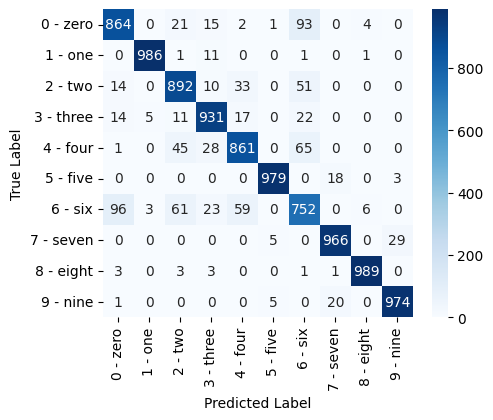

In [42]:
# Train model with parameters in test 3
params_3 = get_params_3()
untrained_model = CNN(*params_3)
model = train_model(untrained_model, train_loader, test_loader, epochs, learning_rate)

100%|██████████| 79/79 [00:01<00:00, 43.51it/s]



Epoch 1, Train Loss: 0.68, Train accuracy: 74.58%, Test accuracy: 83.08%, Test loss: 0.45




100%|██████████| 79/79 [00:01<00:00, 40.77it/s]



Epoch 2, Train Loss: 0.47, Train accuracy: 82.56%, Test accuracy: 86.68%, Test loss: 0.36




100%|██████████| 79/79 [00:01<00:00, 41.33it/s]



Epoch 3, Train Loss: 0.41, Train accuracy: 84.78%, Test accuracy: 87.05%, Test loss: 0.34




100%|██████████| 79/79 [00:01<00:00, 42.30it/s]



Epoch 4, Train Loss: 0.38, Train accuracy: 86.00%, Test accuracy: 88.03%, Test loss: 0.31




100%|██████████| 79/79 [00:02<00:00, 28.47it/s]



Epoch 5, Train Loss: 0.36, Train accuracy: 86.69%, Test accuracy: 89.01%, Test loss: 0.30




100%|██████████| 79/79 [00:01<00:00, 40.60it/s]



Epoch 6, Train Loss: 0.34, Train accuracy: 87.62%, Test accuracy: 89.11%, Test loss: 0.30




100%|██████████| 79/79 [00:01<00:00, 42.04it/s]



Epoch 7, Train Loss: 0.33, Train accuracy: 87.74%, Test accuracy: 90.01%, Test loss: 0.28




100%|██████████| 79/79 [00:01<00:00, 42.85it/s]



Epoch 8, Train Loss: 0.32, Train accuracy: 88.02%, Test accuracy: 89.86%, Test loss: 0.28




100%|██████████| 79/79 [00:01<00:00, 42.34it/s]



Epoch 9, Train Loss: 0.31, Train accuracy: 88.57%, Test accuracy: 89.99%, Test loss: 0.28




100%|██████████| 79/79 [00:02<00:00, 31.01it/s]



Epoch 10, Train Loss: 0.30, Train accuracy: 88.74%, Test accuracy: 90.13%, Test loss: 0.27




100%|██████████| 79/79 [00:01<00:00, 42.44it/s]



Epoch 11, Train Loss: 0.30, Train accuracy: 88.99%, Test accuracy: 90.21%, Test loss: 0.26




100%|██████████| 79/79 [00:01<00:00, 43.47it/s]



Epoch 12, Train Loss: 0.29, Train accuracy: 88.99%, Test accuracy: 90.80%, Test loss: 0.26




100%|██████████| 79/79 [00:01<00:00, 43.73it/s]



Epoch 13, Train Loss: 0.29, Train accuracy: 89.44%, Test accuracy: 91.28%, Test loss: 0.25




100%|██████████| 79/79 [00:01<00:00, 43.73it/s]



Epoch 14, Train Loss: 0.28, Train accuracy: 89.67%, Test accuracy: 91.01%, Test loss: 0.26




100%|██████████| 79/79 [00:02<00:00, 35.67it/s]



Epoch 15, Train Loss: 0.28, Train accuracy: 89.62%, Test accuracy: 91.27%, Test loss: 0.24


Training time: 344.68 seconds


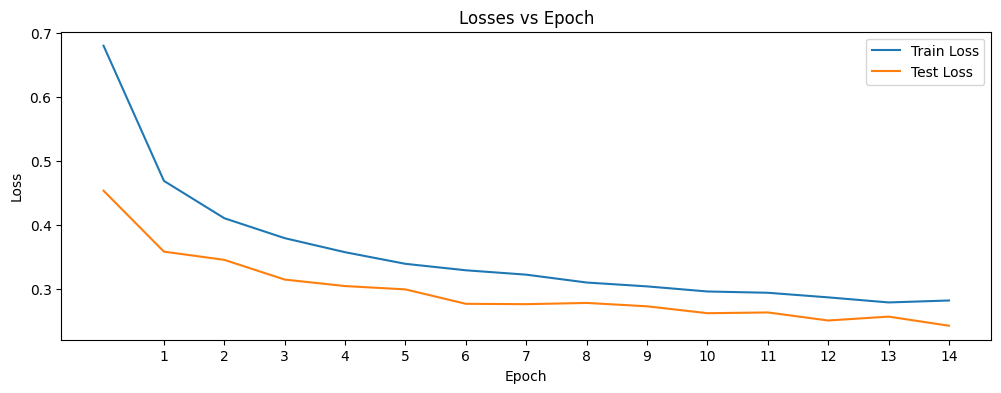

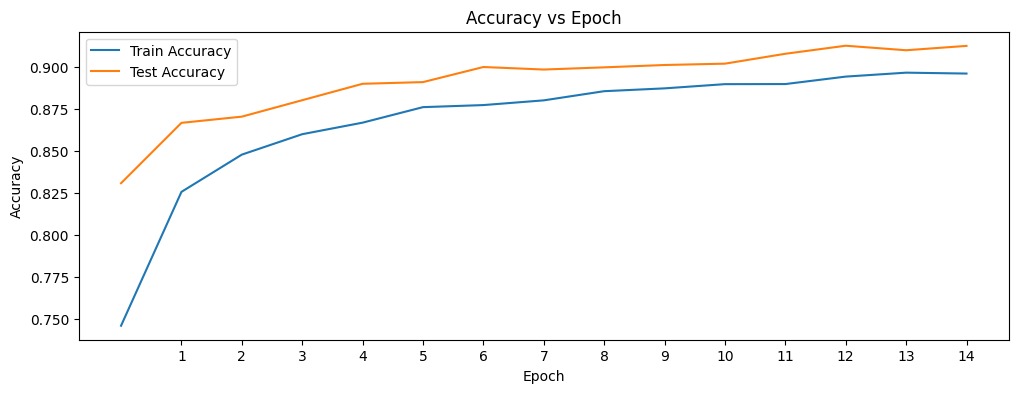

100%|██████████| 79/79 [00:02<00:00, 35.23it/s]


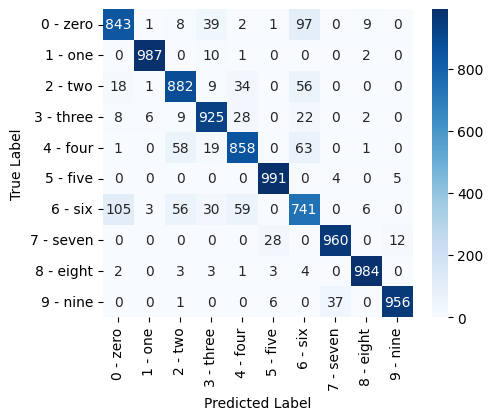

In [43]:
# Train model with parameters in test 4
params_4 = get_params_4()
untrained_model = CNN(*params_4)
model = train_model(untrained_model, train_loader, test_loader, epochs, learning_rate)

100%|██████████| 79/79 [00:02<00:00, 35.76it/s]



Epoch 1, Train Loss: 0.63, Train accuracy: 76.39%, Test accuracy: 85.60%, Test loss: 0.38




100%|██████████| 79/79 [00:01<00:00, 42.14it/s]



Epoch 2, Train Loss: 0.43, Train accuracy: 84.00%, Test accuracy: 87.75%, Test loss: 0.34




100%|██████████| 79/79 [00:01<00:00, 42.90it/s]



Epoch 3, Train Loss: 0.38, Train accuracy: 86.04%, Test accuracy: 88.71%, Test loss: 0.32




100%|██████████| 79/79 [00:01<00:00, 43.16it/s]



Epoch 4, Train Loss: 0.35, Train accuracy: 87.02%, Test accuracy: 89.23%, Test loss: 0.29




100%|██████████| 79/79 [00:02<00:00, 29.74it/s]



Epoch 5, Train Loss: 0.33, Train accuracy: 87.86%, Test accuracy: 89.86%, Test loss: 0.28




100%|██████████| 79/79 [00:01<00:00, 42.73it/s]



Epoch 6, Train Loss: 0.32, Train accuracy: 88.38%, Test accuracy: 89.47%, Test loss: 0.28




100%|██████████| 79/79 [00:01<00:00, 44.22it/s]



Epoch 7, Train Loss: 0.31, Train accuracy: 88.60%, Test accuracy: 90.19%, Test loss: 0.27




100%|██████████| 79/79 [00:01<00:00, 43.18it/s]



Epoch 8, Train Loss: 0.29, Train accuracy: 89.00%, Test accuracy: 90.36%, Test loss: 0.27




100%|██████████| 79/79 [00:02<00:00, 37.90it/s]



Epoch 9, Train Loss: 0.29, Train accuracy: 89.47%, Test accuracy: 89.51%, Test loss: 0.28




100%|██████████| 79/79 [00:01<00:00, 43.42it/s]



Epoch 10, Train Loss: 0.28, Train accuracy: 89.64%, Test accuracy: 91.57%, Test loss: 0.24




100%|██████████| 79/79 [00:01<00:00, 43.00it/s]



Epoch 11, Train Loss: 0.27, Train accuracy: 89.64%, Test accuracy: 91.33%, Test loss: 0.24




100%|██████████| 79/79 [00:01<00:00, 43.31it/s]



Epoch 12, Train Loss: 0.27, Train accuracy: 89.99%, Test accuracy: 91.63%, Test loss: 0.23




100%|██████████| 79/79 [00:01<00:00, 42.17it/s]



Epoch 13, Train Loss: 0.27, Train accuracy: 90.04%, Test accuracy: 91.63%, Test loss: 0.23




100%|██████████| 79/79 [00:02<00:00, 34.53it/s]



Epoch 14, Train Loss: 0.26, Train accuracy: 90.28%, Test accuracy: 91.63%, Test loss: 0.24




100%|██████████| 79/79 [00:01<00:00, 43.85it/s]



Epoch 15, Train Loss: 0.25, Train accuracy: 90.64%, Test accuracy: 91.15%, Test loss: 0.24


Training time: 338.43 seconds


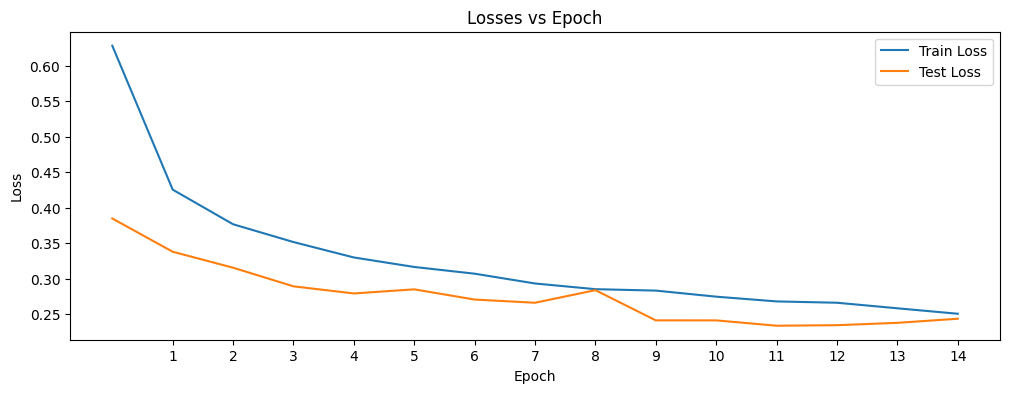

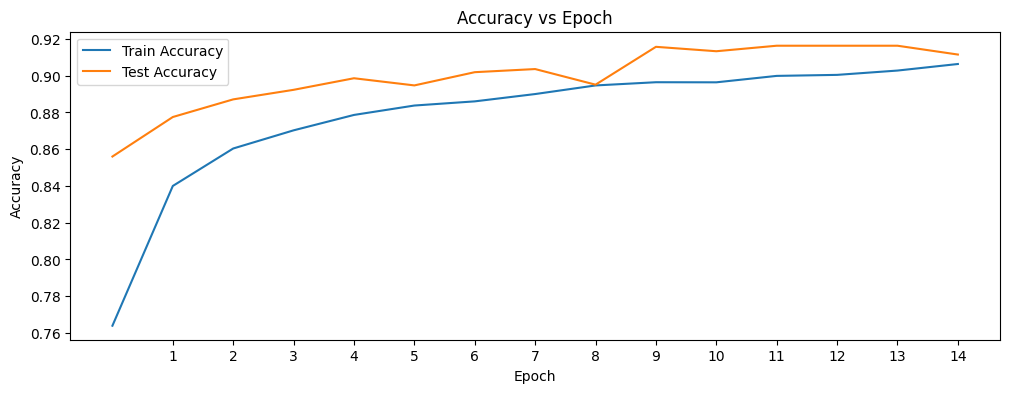

100%|██████████| 79/79 [00:02<00:00, 39.44it/s]


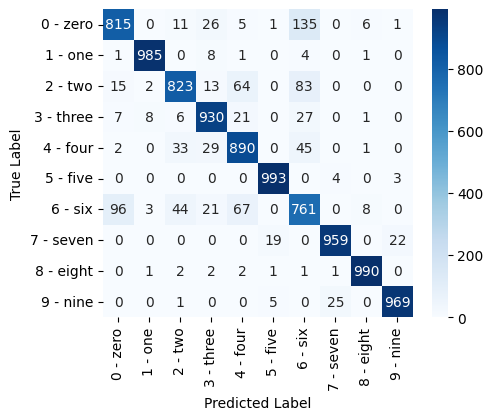

In [44]:
# Train model with parameters in test 5
params_5 = get_params_5()
untrained_model = CNN(*params_5)
model = train_model(untrained_model, train_loader, test_loader, epochs, learning_rate)

## ResNet Pretrained Model

In [10]:
def get_params(learning_rate = 0.001, out_features = 256):
  # Get pretrained resnet model with default weights
  weights = ResNet18_Weights.DEFAULT
  resnet = resnet18(weights=weights)

  # Define the epochs and datasets
  train_loader, test_loader = get_datasets(is_Resnet=True)
  epochs = 15

  # Freeze all the pretrained resnet params
  for param in resnet.parameters():
    param.requires_grad = False

  # Define a new fully connected layer
  resnet.fc = nn.Sequential(
      nn.Linear(in_features=resnet.fc.in_features, out_features=out_features),
      nn.ReLU(),
      nn.Dropout(0.25),
      nn.Linear(in_features=out_features, out_features=10)
  )

  return resnet, epochs, learning_rate, train_loader, test_loader

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 192MB/s]
100%|██████████| 26.4M/26.4M [00:02<00:00, 13.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 204kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.81MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 15.1MB/s]


Getting datasets for ResNet model


100%|██████████| 79/79 [00:02<00:00, 26.82it/s]



Epoch 1, Train Loss: 1.09, Train accuracy: 62.24%, Test accuracy: 70.33%, Test loss: 0.84




100%|██████████| 79/79 [00:03<00:00, 21.95it/s]



Epoch 2, Train Loss: 0.87, Train accuracy: 69.10%, Test accuracy: 72.54%, Test loss: 0.78




100%|██████████| 79/79 [00:03<00:00, 21.99it/s]



Epoch 3, Train Loss: 0.83, Train accuracy: 70.27%, Test accuracy: 72.70%, Test loss: 0.76




100%|██████████| 79/79 [00:03<00:00, 26.05it/s]



Epoch 4, Train Loss: 0.80, Train accuracy: 71.27%, Test accuracy: 73.08%, Test loss: 0.74




100%|██████████| 79/79 [00:02<00:00, 26.62it/s]



Epoch 5, Train Loss: 0.79, Train accuracy: 71.80%, Test accuracy: 73.24%, Test loss: 0.74




100%|██████████| 79/79 [00:03<00:00, 25.40it/s]



Epoch 6, Train Loss: 0.77, Train accuracy: 72.24%, Test accuracy: 73.77%, Test loss: 0.73




100%|██████████| 79/79 [00:04<00:00, 18.83it/s]



Epoch 7, Train Loss: 0.76, Train accuracy: 72.32%, Test accuracy: 74.29%, Test loss: 0.71




100%|██████████| 79/79 [00:04<00:00, 19.65it/s]



Epoch 8, Train Loss: 0.75, Train accuracy: 72.94%, Test accuracy: 74.44%, Test loss: 0.71




100%|██████████| 79/79 [00:03<00:00, 24.76it/s]



Epoch 9, Train Loss: 0.75, Train accuracy: 72.77%, Test accuracy: 74.80%, Test loss: 0.71




100%|██████████| 79/79 [00:03<00:00, 25.29it/s]



Epoch 10, Train Loss: 0.74, Train accuracy: 73.37%, Test accuracy: 74.67%, Test loss: 0.71




100%|██████████| 79/79 [00:03<00:00, 25.57it/s]



Epoch 11, Train Loss: 0.74, Train accuracy: 73.35%, Test accuracy: 74.54%, Test loss: 0.70




100%|██████████| 79/79 [00:03<00:00, 24.57it/s]



Epoch 12, Train Loss: 0.73, Train accuracy: 73.57%, Test accuracy: 74.81%, Test loss: 0.69




100%|██████████| 79/79 [00:04<00:00, 19.40it/s]



Epoch 13, Train Loss: 0.72, Train accuracy: 73.66%, Test accuracy: 75.00%, Test loss: 0.69




100%|██████████| 79/79 [00:03<00:00, 25.17it/s]



Epoch 14, Train Loss: 0.72, Train accuracy: 73.65%, Test accuracy: 74.82%, Test loss: 0.70




100%|██████████| 79/79 [00:03<00:00, 25.38it/s]



Epoch 15, Train Loss: 0.72, Train accuracy: 74.17%, Test accuracy: 75.48%, Test loss: 0.69


Training time: 344.74 seconds


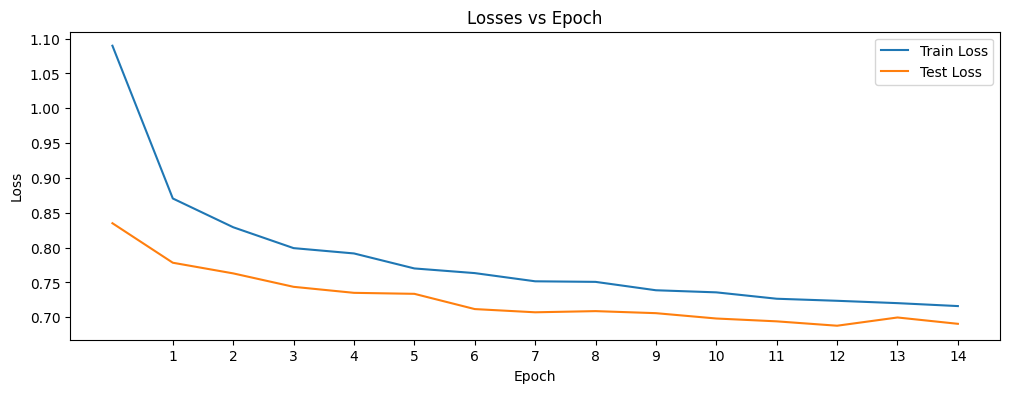

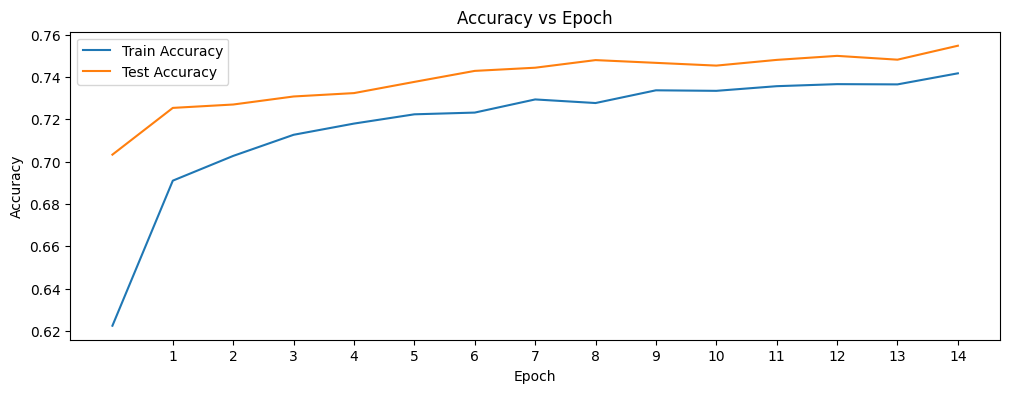

100%|██████████| 79/79 [00:03<00:00, 20.99it/s]


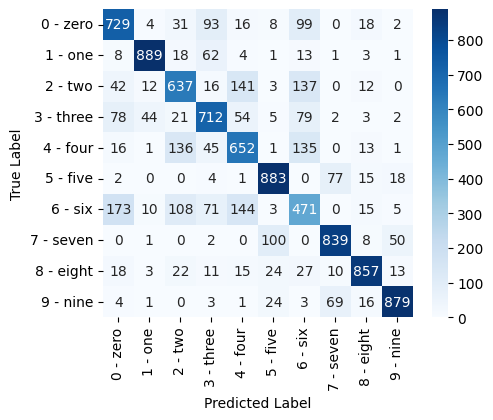

In [11]:
# Train model with learning rate of 0.001 and 64 nodes on fully connected layer
resnet, epochs, learning_rate, train_loader, test_loader = get_params(0.001, 64)
model = train_model(resnet, train_loader, test_loader, epochs, learning_rate)

Getting datasets for ResNet model


100%|██████████| 79/79 [00:03<00:00, 24.47it/s]



Epoch 1, Train Loss: 1.20, Train accuracy: 59.24%, Test accuracy: 69.61%, Test loss: 0.88




100%|██████████| 79/79 [00:03<00:00, 22.78it/s]



Epoch 2, Train Loss: 0.91, Train accuracy: 68.17%, Test accuracy: 71.60%, Test loss: 0.81




100%|██████████| 79/79 [00:03<00:00, 19.77it/s]



Epoch 3, Train Loss: 0.85, Train accuracy: 70.00%, Test accuracy: 72.78%, Test loss: 0.77




100%|██████████| 79/79 [00:03<00:00, 25.07it/s]



Epoch 4, Train Loss: 0.82, Train accuracy: 70.80%, Test accuracy: 73.65%, Test loss: 0.75




100%|██████████| 79/79 [00:03<00:00, 25.03it/s]



Epoch 5, Train Loss: 0.80, Train accuracy: 71.42%, Test accuracy: 73.64%, Test loss: 0.74




100%|██████████| 79/79 [00:03<00:00, 25.54it/s]



Epoch 6, Train Loss: 0.78, Train accuracy: 72.03%, Test accuracy: 73.88%, Test loss: 0.73




100%|██████████| 79/79 [00:03<00:00, 22.41it/s]



Epoch 7, Train Loss: 0.76, Train accuracy: 72.69%, Test accuracy: 74.59%, Test loss: 0.72




100%|██████████| 79/79 [00:04<00:00, 19.31it/s]



Epoch 8, Train Loss: 0.76, Train accuracy: 72.78%, Test accuracy: 74.30%, Test loss: 0.71




100%|██████████| 79/79 [00:03<00:00, 25.23it/s]



Epoch 9, Train Loss: 0.75, Train accuracy: 73.00%, Test accuracy: 74.43%, Test loss: 0.71




100%|██████████| 79/79 [00:02<00:00, 26.55it/s]



Epoch 10, Train Loss: 0.74, Train accuracy: 73.38%, Test accuracy: 74.58%, Test loss: 0.71




100%|██████████| 79/79 [00:03<00:00, 25.86it/s]



Epoch 11, Train Loss: 0.73, Train accuracy: 73.56%, Test accuracy: 74.33%, Test loss: 0.71




100%|██████████| 79/79 [00:03<00:00, 21.12it/s]



Epoch 12, Train Loss: 0.73, Train accuracy: 73.68%, Test accuracy: 74.95%, Test loss: 0.70




100%|██████████| 79/79 [00:03<00:00, 21.77it/s]



Epoch 13, Train Loss: 0.72, Train accuracy: 73.93%, Test accuracy: 74.74%, Test loss: 0.70




100%|██████████| 79/79 [00:03<00:00, 25.67it/s]



Epoch 14, Train Loss: 0.72, Train accuracy: 74.24%, Test accuracy: 75.19%, Test loss: 0.69




100%|██████████| 79/79 [00:02<00:00, 26.54it/s]



Epoch 15, Train Loss: 0.71, Train accuracy: 74.28%, Test accuracy: 75.14%, Test loss: 0.69


Training time: 343.53 seconds


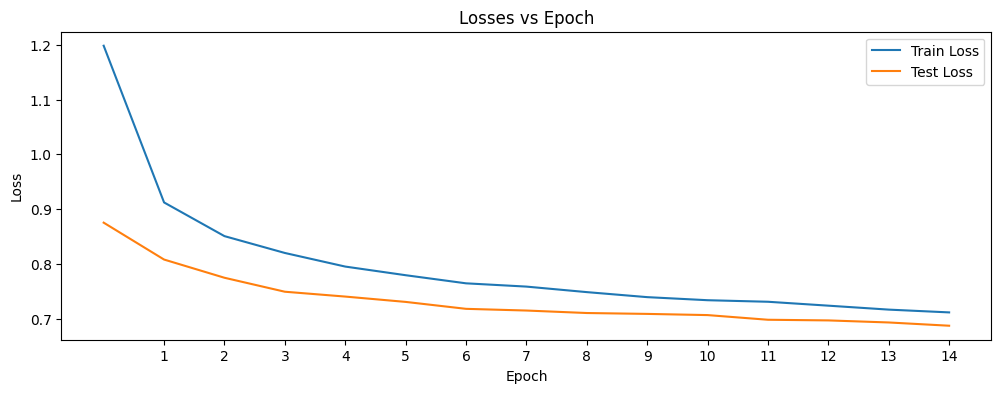

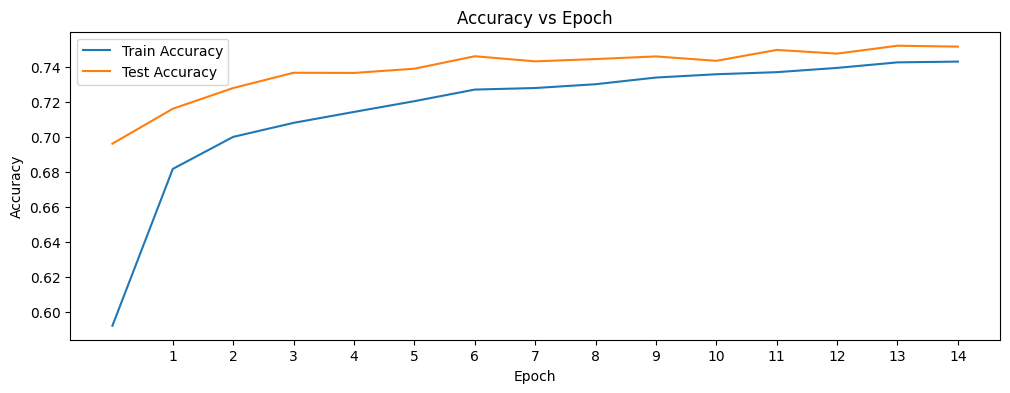

100%|██████████| 79/79 [00:02<00:00, 26.44it/s]


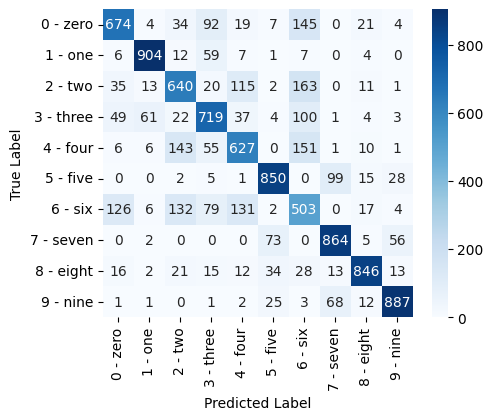

In [12]:
# Train model with learning rate of 0.0005 and 64 nodes on fully connected layer
resnet, epochs, learning_rate, train_loader, test_loader = get_params(0.0005, 64)
model = train_model(resnet, train_loader, test_loader, epochs, learning_rate)

Getting datasets for ResNet model


100%|██████████| 79/79 [00:03<00:00, 23.00it/s]



Epoch 1, Train Loss: 1.03, Train accuracy: 64.24%, Test accuracy: 71.65%, Test loss: 0.80




100%|██████████| 79/79 [00:03<00:00, 25.15it/s]



Epoch 2, Train Loss: 0.83, Train accuracy: 70.52%, Test accuracy: 72.27%, Test loss: 0.77




100%|██████████| 79/79 [00:02<00:00, 27.26it/s]



Epoch 3, Train Loss: 0.79, Train accuracy: 71.92%, Test accuracy: 72.82%, Test loss: 0.74




100%|██████████| 79/79 [00:02<00:00, 27.12it/s]



Epoch 4, Train Loss: 0.76, Train accuracy: 72.76%, Test accuracy: 74.08%, Test loss: 0.72




100%|██████████| 79/79 [00:03<00:00, 21.14it/s]



Epoch 5, Train Loss: 0.73, Train accuracy: 73.67%, Test accuracy: 74.54%, Test loss: 0.71




100%|██████████| 79/79 [00:03<00:00, 23.92it/s]



Epoch 6, Train Loss: 0.72, Train accuracy: 73.86%, Test accuracy: 75.03%, Test loss: 0.70




100%|██████████| 79/79 [00:03<00:00, 25.73it/s]



Epoch 7, Train Loss: 0.70, Train accuracy: 74.43%, Test accuracy: 75.30%, Test loss: 0.69




100%|██████████| 79/79 [00:02<00:00, 27.18it/s]



Epoch 8, Train Loss: 0.70, Train accuracy: 74.67%, Test accuracy: 74.85%, Test loss: 0.70




100%|██████████| 79/79 [00:03<00:00, 22.19it/s]



Epoch 9, Train Loss: 0.68, Train accuracy: 75.19%, Test accuracy: 75.11%, Test loss: 0.69




100%|██████████| 79/79 [00:02<00:00, 27.17it/s]



Epoch 10, Train Loss: 0.68, Train accuracy: 75.48%, Test accuracy: 75.87%, Test loss: 0.67




100%|██████████| 79/79 [00:03<00:00, 25.93it/s]



Epoch 11, Train Loss: 0.67, Train accuracy: 75.50%, Test accuracy: 75.54%, Test loss: 0.67




100%|██████████| 79/79 [00:02<00:00, 26.70it/s]



Epoch 12, Train Loss: 0.66, Train accuracy: 75.85%, Test accuracy: 76.05%, Test loss: 0.67




100%|██████████| 79/79 [00:03<00:00, 20.47it/s]



Epoch 13, Train Loss: 0.66, Train accuracy: 76.03%, Test accuracy: 75.63%, Test loss: 0.67




100%|██████████| 79/79 [00:03<00:00, 24.36it/s]



Epoch 14, Train Loss: 0.66, Train accuracy: 76.13%, Test accuracy: 76.12%, Test loss: 0.67




100%|██████████| 79/79 [00:02<00:00, 26.85it/s]



Epoch 15, Train Loss: 0.65, Train accuracy: 76.07%, Test accuracy: 76.66%, Test loss: 0.66


Training time: 332.68 seconds


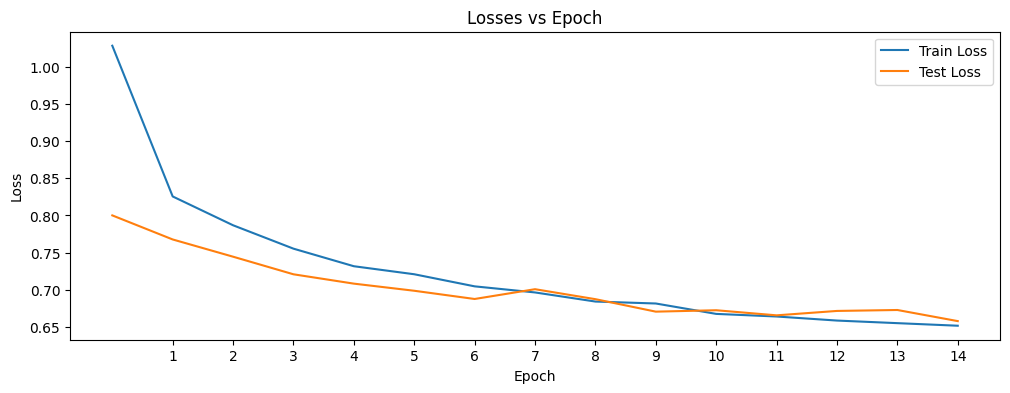

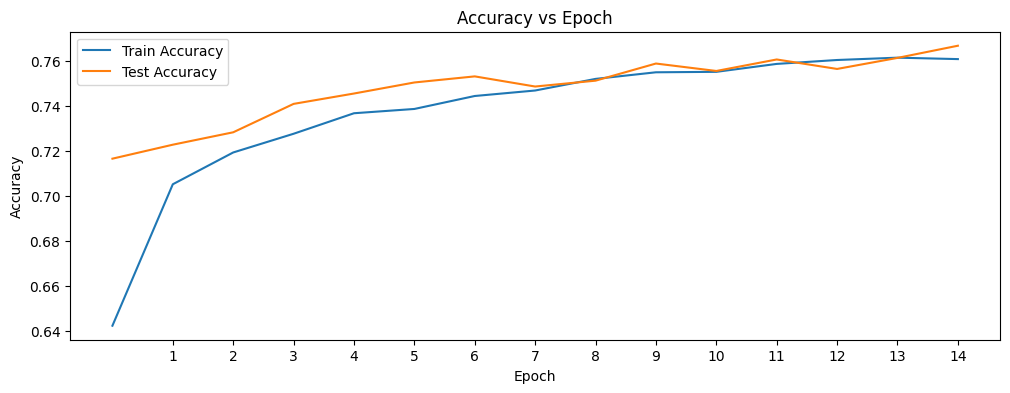

100%|██████████| 79/79 [00:03<00:00, 20.57it/s]


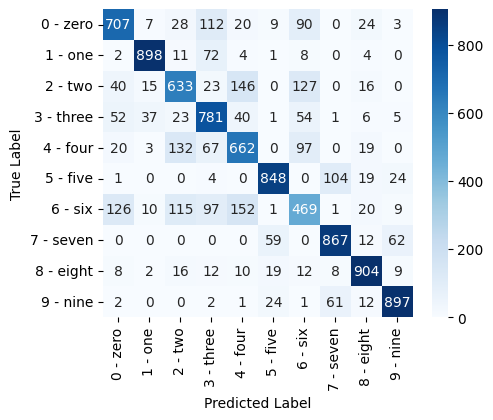

In [13]:
# Train model with learning rate of 0.001 and 128 nodes on fully connected layer
resnet, epochs, learning_rate, train_loader, test_loader = get_params(0.001, 128)
model = train_model(resnet, train_loader, test_loader, epochs, learning_rate)

Getting datasets for ResNet model


100%|██████████| 79/79 [00:03<00:00, 25.57it/s]



Epoch 1, Train Loss: 1.12, Train accuracy: 61.82%, Test accuracy: 71.05%, Test loss: 0.85




100%|██████████| 79/79 [00:03<00:00, 20.01it/s]



Epoch 2, Train Loss: 0.87, Train accuracy: 69.58%, Test accuracy: 72.92%, Test loss: 0.79




100%|██████████| 79/79 [00:02<00:00, 26.80it/s]



Epoch 3, Train Loss: 0.82, Train accuracy: 71.21%, Test accuracy: 73.00%, Test loss: 0.76




100%|██████████| 79/79 [00:03<00:00, 25.70it/s]



Epoch 4, Train Loss: 0.78, Train accuracy: 72.04%, Test accuracy: 74.21%, Test loss: 0.73




100%|██████████| 79/79 [00:02<00:00, 26.85it/s]



Epoch 5, Train Loss: 0.75, Train accuracy: 73.08%, Test accuracy: 74.52%, Test loss: 0.71




100%|██████████| 79/79 [00:03<00:00, 20.68it/s]



Epoch 6, Train Loss: 0.74, Train accuracy: 73.56%, Test accuracy: 74.45%, Test loss: 0.72




100%|██████████| 79/79 [00:03<00:00, 25.16it/s]



Epoch 7, Train Loss: 0.72, Train accuracy: 74.32%, Test accuracy: 75.09%, Test loss: 0.70




100%|██████████| 79/79 [00:03<00:00, 26.29it/s]



Epoch 8, Train Loss: 0.71, Train accuracy: 74.56%, Test accuracy: 75.71%, Test loss: 0.69




100%|██████████| 79/79 [00:02<00:00, 26.37it/s]



Epoch 9, Train Loss: 0.70, Train accuracy: 74.97%, Test accuracy: 75.11%, Test loss: 0.69




100%|██████████| 79/79 [00:03<00:00, 20.97it/s]



Epoch 10, Train Loss: 0.69, Train accuracy: 75.06%, Test accuracy: 76.14%, Test loss: 0.68




100%|██████████| 79/79 [00:03<00:00, 25.58it/s]



Epoch 11, Train Loss: 0.68, Train accuracy: 75.64%, Test accuracy: 76.06%, Test loss: 0.67




100%|██████████| 79/79 [00:03<00:00, 25.91it/s]



Epoch 12, Train Loss: 0.67, Train accuracy: 75.94%, Test accuracy: 75.98%, Test loss: 0.68




100%|██████████| 79/79 [00:02<00:00, 26.80it/s]



Epoch 13, Train Loss: 0.66, Train accuracy: 76.26%, Test accuracy: 75.92%, Test loss: 0.67




100%|██████████| 79/79 [00:03<00:00, 22.92it/s]



Epoch 14, Train Loss: 0.65, Train accuracy: 76.34%, Test accuracy: 76.28%, Test loss: 0.66




100%|██████████| 79/79 [00:03<00:00, 21.90it/s]



Epoch 15, Train Loss: 0.65, Train accuracy: 76.71%, Test accuracy: 76.27%, Test loss: 0.67


Training time: 334.39 seconds


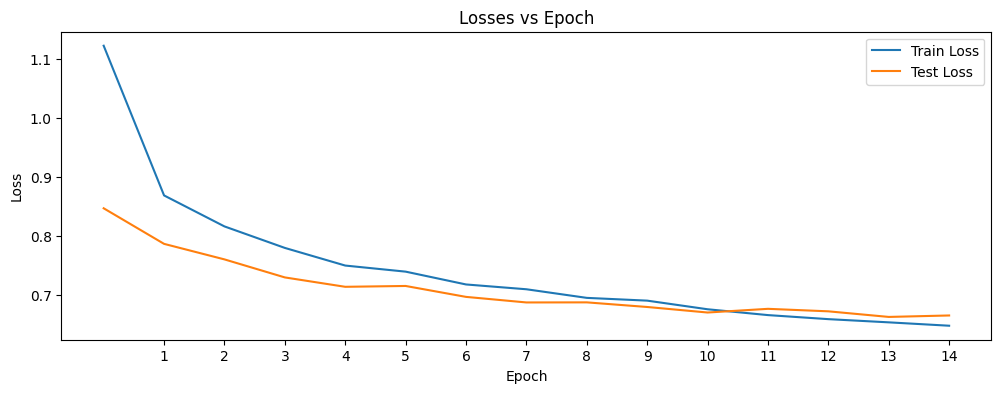

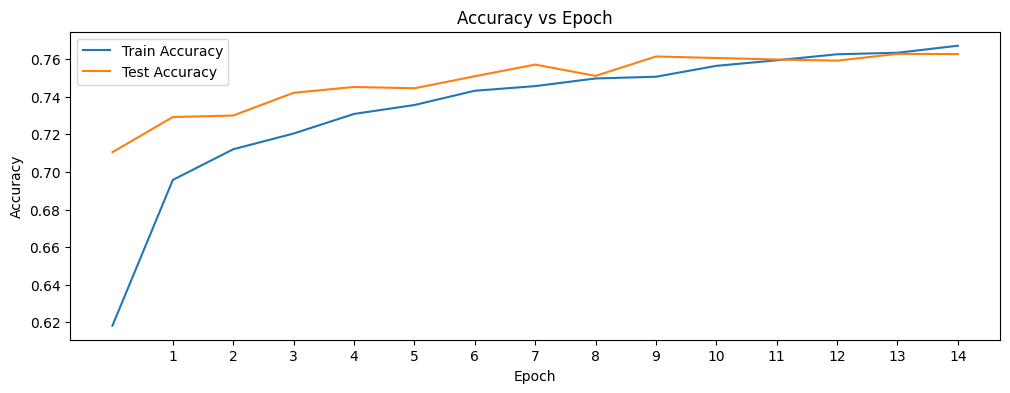

100%|██████████| 79/79 [00:03<00:00, 25.05it/s]


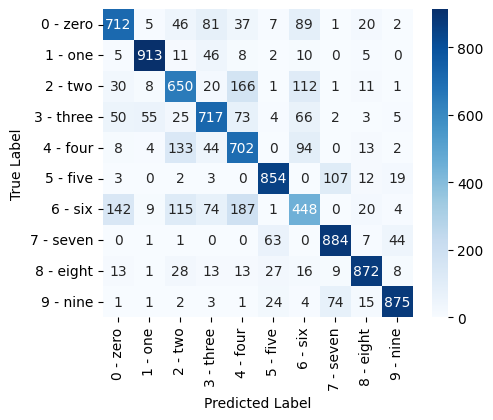

In [14]:
# Train model with learning rate of 0.0005 and 128 nodes on fully connected layer
resnet, epochs, learning_rate, train_loader, test_loader = get_params(0.0005, 128)
model = train_model(resnet, train_loader, test_loader, epochs, learning_rate)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 133MB/s]


Getting datasets for ResNet model


100%|██████████| 79/79 [00:03<00:00, 25.94it/s]



Epoch 1, Train Loss: 1.00, Train accuracy: 65.16%, Test accuracy: 71.57%, Test loss: 0.80




100%|██████████| 79/79 [00:03<00:00, 19.85it/s]



Epoch 2, Train Loss: 0.81, Train accuracy: 71.22%, Test accuracy: 73.70%, Test loss: 0.74




100%|██████████| 79/79 [00:03<00:00, 24.71it/s]



Epoch 3, Train Loss: 0.75, Train accuracy: 72.97%, Test accuracy: 74.69%, Test loss: 0.70




100%|██████████| 79/79 [00:02<00:00, 26.74it/s]



Epoch 4, Train Loss: 0.72, Train accuracy: 73.95%, Test accuracy: 74.83%, Test loss: 0.70




100%|██████████| 79/79 [00:03<00:00, 26.25it/s]



Epoch 5, Train Loss: 0.70, Train accuracy: 74.86%, Test accuracy: 75.50%, Test loss: 0.69




100%|██████████| 79/79 [00:03<00:00, 25.52it/s]



Epoch 6, Train Loss: 0.68, Train accuracy: 75.34%, Test accuracy: 75.67%, Test loss: 0.68




100%|██████████| 79/79 [00:04<00:00, 19.69it/s]



Epoch 7, Train Loss: 0.66, Train accuracy: 75.87%, Test accuracy: 75.90%, Test loss: 0.68




100%|██████████| 79/79 [00:03<00:00, 26.15it/s]



Epoch 8, Train Loss: 0.65, Train accuracy: 76.26%, Test accuracy: 75.35%, Test loss: 0.69




100%|██████████| 79/79 [00:03<00:00, 25.92it/s]



Epoch 9, Train Loss: 0.64, Train accuracy: 76.79%, Test accuracy: 76.20%, Test loss: 0.66




100%|██████████| 79/79 [00:03<00:00, 26.23it/s]



Epoch 10, Train Loss: 0.63, Train accuracy: 76.78%, Test accuracy: 75.83%, Test loss: 0.67




100%|██████████| 79/79 [00:03<00:00, 21.10it/s]



Epoch 11, Train Loss: 0.62, Train accuracy: 77.34%, Test accuracy: 76.08%, Test loss: 0.67




100%|██████████| 79/79 [00:03<00:00, 23.20it/s]



Epoch 12, Train Loss: 0.61, Train accuracy: 77.66%, Test accuracy: 76.17%, Test loss: 0.67




100%|██████████| 79/79 [00:03<00:00, 25.91it/s]



Epoch 13, Train Loss: 0.60, Train accuracy: 77.81%, Test accuracy: 76.28%, Test loss: 0.66




100%|██████████| 79/79 [00:03<00:00, 25.81it/s]



Epoch 14, Train Loss: 0.60, Train accuracy: 77.99%, Test accuracy: 75.72%, Test loss: 0.67




100%|██████████| 79/79 [00:03<00:00, 25.79it/s]



Epoch 15, Train Loss: 0.59, Train accuracy: 78.40%, Test accuracy: 76.14%, Test loss: 0.66


Training time: 341.74 seconds


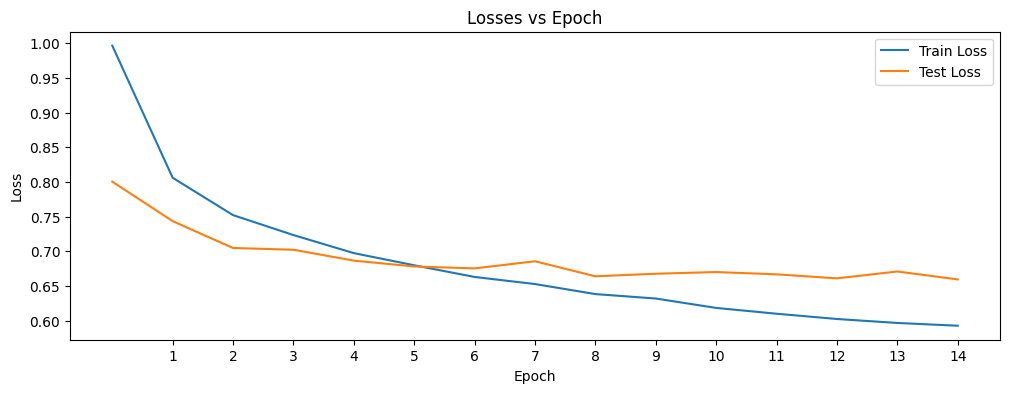

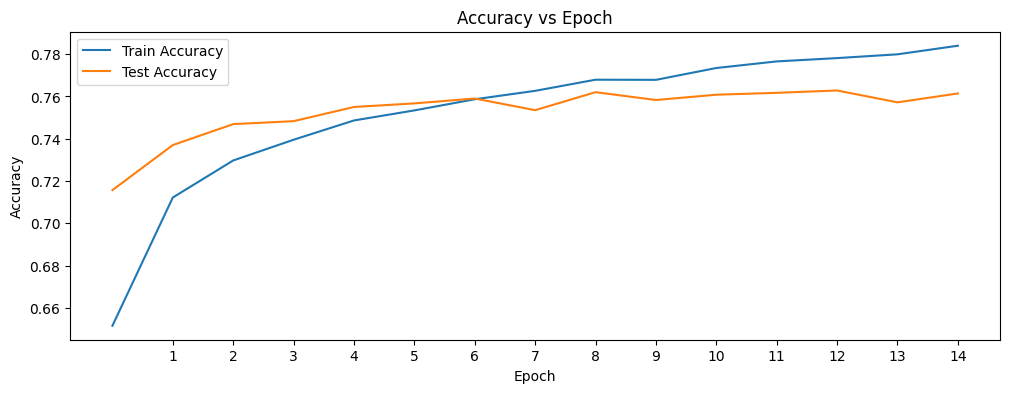

100%|██████████| 79/79 [00:03<00:00, 26.03it/s]


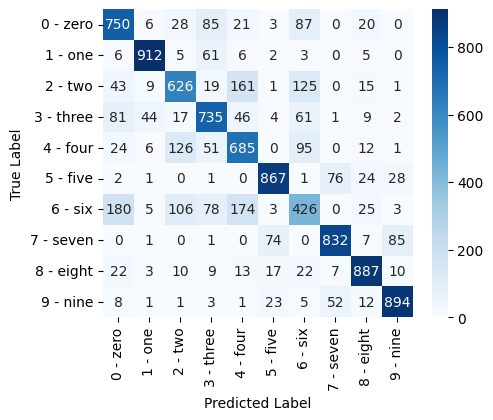

In [46]:
# Train model with learning rate of 0.001 and 256 nodes on fully connected layer
resnet, epochs, learning_rate, train_loader, test_loader = get_params(0.001, 256)
model = train_model(resnet, train_loader, test_loader, epochs, learning_rate)

Getting datasets for ResNet model


100%|██████████| 79/79 [00:03<00:00, 22.21it/s]



Epoch 1, Train Loss: 1.05, Train accuracy: 63.98%, Test accuracy: 71.26%, Test loss: 0.83




100%|██████████| 79/79 [00:03<00:00, 25.36it/s]



Epoch 2, Train Loss: 0.83, Train accuracy: 70.52%, Test accuracy: 72.77%, Test loss: 0.77




100%|██████████| 79/79 [00:03<00:00, 25.79it/s]



Epoch 3, Train Loss: 0.78, Train accuracy: 72.30%, Test accuracy: 73.44%, Test loss: 0.74




100%|██████████| 79/79 [00:03<00:00, 25.96it/s]



Epoch 4, Train Loss: 0.74, Train accuracy: 73.39%, Test accuracy: 74.39%, Test loss: 0.73




100%|██████████| 79/79 [00:03<00:00, 21.57it/s]



Epoch 5, Train Loss: 0.71, Train accuracy: 74.57%, Test accuracy: 74.79%, Test loss: 0.70




100%|██████████| 79/79 [00:03<00:00, 20.32it/s]



Epoch 6, Train Loss: 0.69, Train accuracy: 75.10%, Test accuracy: 75.81%, Test loss: 0.69




100%|██████████| 79/79 [00:03<00:00, 25.64it/s]



Epoch 7, Train Loss: 0.68, Train accuracy: 75.58%, Test accuracy: 75.67%, Test loss: 0.69




100%|██████████| 79/79 [00:03<00:00, 25.63it/s]



Epoch 8, Train Loss: 0.66, Train accuracy: 76.22%, Test accuracy: 76.47%, Test loss: 0.67




100%|██████████| 79/79 [00:03<00:00, 25.77it/s]



Epoch 9, Train Loss: 0.65, Train accuracy: 76.54%, Test accuracy: 76.07%, Test loss: 0.66




100%|██████████| 79/79 [00:03<00:00, 22.29it/s]



Epoch 10, Train Loss: 0.64, Train accuracy: 76.98%, Test accuracy: 76.11%, Test loss: 0.67




100%|██████████| 79/79 [00:04<00:00, 19.73it/s]



Epoch 11, Train Loss: 0.62, Train accuracy: 77.39%, Test accuracy: 76.77%, Test loss: 0.65




100%|██████████| 79/79 [00:03<00:00, 24.30it/s]



Epoch 12, Train Loss: 0.62, Train accuracy: 77.58%, Test accuracy: 75.96%, Test loss: 0.66




100%|██████████| 79/79 [00:03<00:00, 25.70it/s]



Epoch 13, Train Loss: 0.61, Train accuracy: 77.91%, Test accuracy: 76.84%, Test loss: 0.65




100%|██████████| 79/79 [00:03<00:00, 25.44it/s]



Epoch 14, Train Loss: 0.60, Train accuracy: 78.14%, Test accuracy: 76.77%, Test loss: 0.65




100%|██████████| 79/79 [00:03<00:00, 24.61it/s]



Epoch 15, Train Loss: 0.59, Train accuracy: 78.46%, Test accuracy: 76.74%, Test loss: 0.65


Training time: 345.94 seconds


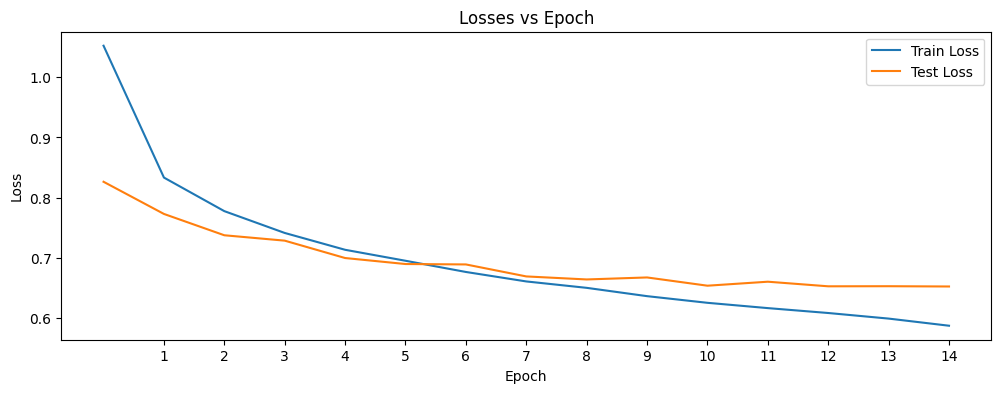

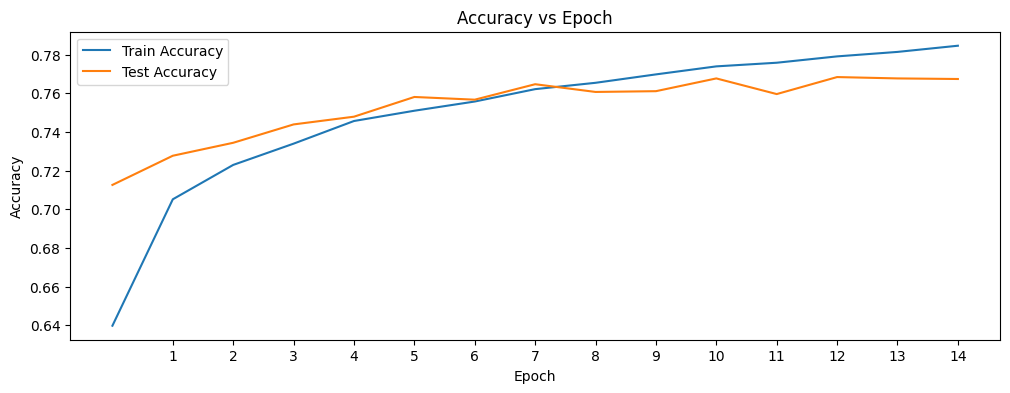

100%|██████████| 79/79 [00:03<00:00, 25.89it/s]


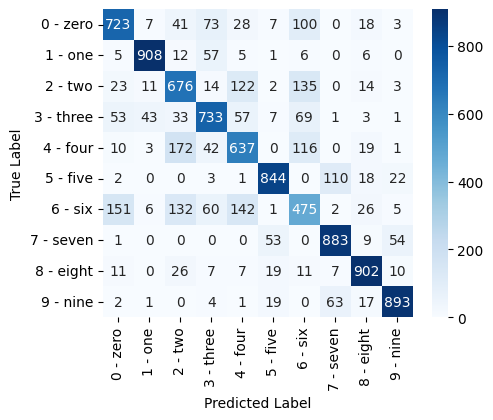

In [47]:
# Train model with learning rate of 0.0005 and 256 nodes on fully connected layer
resnet, epochs, learning_rate, train_loader, test_loader = get_params(0.0005, 256)
model = train_model(resnet, train_loader, test_loader, epochs, learning_rate)